### This code generates SAM map for the 3-layer SNN model.


Mount the drive and append the path to the system

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

import sys
sys.path.append('/content/drive/My Drive/Thesis/')

DATASET_PATH = "/content/drive/My Drive/Thesis/eeg_dataset/"
EXPLAINATIONS_PATH = "/content/drive/My Drive/Thesis/Explanations/"
PATH = "/content/drive/My Drive/Thesis/Model1_simple_SNN.pt"
HISTORY_PATH = "/content/drive/My Drive/Thesis/Model1_simple_SNN.pkl"

Mounted at /content/drive/


Install and import the required package

In [2]:
!pip install autoreject
!pip install mne
!pip install rockpool

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 101.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 501.4/501.4 kB 25.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rockpool: filename=rockpool-2.8-py3-none-any.whl size=602817 sha256=4e1a8fe295322891298354c43845a0b47f02b293207b7129a56c85c86effb9a9
  Stored in directory: /root/.cache/pip/wheels/86/da/b5/d6b52866a6c79c247eb46105b77bb3dab82eb3f567594ccc85
Successfully built rockpool


In [3]:
# - Basic imports
import matplotlib.gridspec as gridspec
import numpy as np
import pickle
import torch

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = [9.6, 3.6]
plt.rcParams['font.size'] = 12

from matplotlib.patches import Rectangle
from poisson import poisson
from rockpool.nn.modules import LIF
from rockpool.nn.modules import LIFTorch, LinearTorch
from rockpool.nn.combinators import Sequential
from rockpool.parameters import Constant
from torch.utils.data import Dataset, DataLoader
from tqdm.autonotebook import tqdm, trange
from utils_all_channels import EegData

<ipython-input-3-6cdedb42c58c>:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


### Load dataset


In [4]:
class EpochsDataset(Dataset):
    """Class to expose an MNE Epochs object as PyTorch dataset.

    Parameters
    ----------
    epochs_data : np.ndarray
        The epochs data, shape (n_epochs, n_channels, n_times).
    epochs_labels : np.ndarray
        The epochs labels, shape (n_epochs,)
    subj_nb: None | int
        Subject number.
    rec_nb: None | int
        Recording number.
    transform : callable | None
        The function apply scalling to each epoch
        for preprocessing.
    """
    def __init__(self, epochs_data, epochs_labels, subj_nb=None,
                 rec_nb=None, transform=None):
        assert len(epochs_data) == len(epochs_labels)
        self.epochs_data = epochs_data
        self.epochs_labels = epochs_labels
        self.subj_nb = subj_nb
        self.rec_nb = rec_nb
        self.transform = transform

    def __len__(self):
        return len(self.epochs_labels)

    def __getitem__(self, idx):
        X, y = self.epochs_data[idx], self.epochs_labels[idx]
        if self.transform is not None:
            X = self.transform(X)
            X = torch.as_tensor(X[None, ...])
        return X, y

### Define the Poisson encoder and decoder

In [5]:
def encode_batch_data(eeg, num_timesteps, scale=1):
    if (eeg.dim() == 3):
        num_batches, frame_x, frame_y = eeg.shape
    elif (eeg.dim() == 2):
        num_batches, frame_x = eeg.shape
    eeg = scale * eeg.view((num_batches, 1, -1)).repeat((1, num_timesteps, 1))
    return (torch.rand(eeg.shape) < (eeg * scale)).float()

def encode_data(eeg, num_timesteps):
    eeg_array = np.array(eeg)
    # Select a single channel from the EEG data
    single_channel_data = eeg_array
    # Normalize the data
    max_data = np.max(single_channel_data)
    min_data = np.min(single_channel_data)
    normalized_data = (single_channel_data - min_data) / (max_data - min_data)

    # Encode the EEG data using the Poisson method
    poisson_spikes = poisson.encode(normalized_data, num_timesteps=num_timesteps)
    decoded_poisson_spikes = poisson.decode(poisson_spikes)* (max_data - min_data) + min_data
    return single_channel_data, poisson_spikes, decoded_poisson_spikes

# - Define a function to encode the network target
def encode_class(class_idx, num_classes, num_timesteps, scale = 1):
    num_batches = class_idx.numel()
    # Generate Poisson events
    target = torch.nn.functional.one_hot(class_idx.long(), num_classes = num_classes)
    return target.view((num_batches, 1, -1)).repeat((1, num_timesteps, 1)).float()

    #return encoded_data

In [7]:
with open(DATASET_PATH + "train/train.pkl", "rb") as f:
   x_train, y_train = pickle.load(f)

with open(DATASET_PATH + "test/test.pkl", "rb") as f:
   x_test, y_test = pickle.load(f)

with open(DATASET_PATH + "valid/valid.pkl", "rb") as f:
   x_val, y_val = pickle.load(f)

# Create dataloaders
train_batch_size = 32  # Important hyperparameter
valid_batch_size = 32  # Can be made as large as what fits in memory; won't impact performance
num_workers = 0  # Number of processes to use for the data loading process; 0 is the main Python process

train_set = EpochsDataset(x_train, y_train)
valid_set = EpochsDataset(x_val, y_val)
test_set = EpochsDataset(x_test, y_test)


print('Number of examples in each set:')
print(f'Training: {len(train_set)}')
print(f'Validation: {len(valid_set)}')
print(f'Test: {len(test_set)}')

loader_train = DataLoader(
    train_set, batch_size=train_batch_size, shuffle=False, num_workers=num_workers)
loader_valid = DataLoader(
    valid_set, batch_size=valid_batch_size, shuffle=False, num_workers=num_workers)
loader_test = DataLoader(
    test_set, batch_size=valid_batch_size, shuffle=False, num_workers=num_workers)


Number of examples in each set:
Training: 3379
Validation: 845
Test: 1056


### Define the model architecture and load the trained model

In [8]:
# - Define a simple network
num_timesteps = 256
num_classes = 2

input_channels = torch.from_numpy(train_set[0][0]).numel()
num_hidden1 = 512
num_hidden2 = 64
output_channels = 2
tau_mem = Constant(2e-2)
tau_syn = Constant(5e-3)
threshold = Constant(0.6)
threshold2 = Constant(0.4)
threshold3 = Constant(0.15)
bias = Constant(0.1)

# - Define the temporal aspects of a data sample
dt = 10e-3
# - Define a two-layer feed-forward SNN
snn = Sequential(
    LinearTorch((input_channels, num_hidden1)),
    LIFTorch(num_hidden1, tau_syn = tau_syn, tau_mem = tau_mem, threshold = threshold, bias = bias, dt = dt),

    LinearTorch((num_hidden1, num_hidden2)),
    LIFTorch(num_hidden2, tau_syn = tau_syn, tau_mem = tau_mem, threshold = threshold2, bias = bias, dt = dt),

    LinearTorch((num_hidden2, output_channels)),
    LIFTorch(2, tau_syn = tau_syn, tau_mem = tau_mem, threshold = threshold3, bias = bias, dt = dt)
)
print(snn)

TorchSequential  with shape (20480, 2) {
    LinearTorch '0_LinearTorch' with shape (20480, 512)
    LIFTorch '1_LIFTorch' with shape (512, 512)
    LinearTorch '2_LinearTorch' with shape (512, 64)
    LIFTorch '3_LIFTorch' with shape (64, 64)
    LinearTorch '4_LinearTorch' with shape (64, 2)
    LIFTorch '5_LIFTorch' with shape (2, 2)
}


In [9]:
# - Determine which device to use for training
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(device)

cuda


In [10]:
def test(model, device, test_loader):
    # - Prepare model for evaluation
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
      # - Loop over the dataset
      for data, class_idx in tqdm(test_loader, desc='Testing', leave=False, unit='batch'):
        # - Encode the input and target
        data = encode_batch_data(data, num_timesteps, scale=1)

        target = encode_class(class_idx, num_classes, num_timesteps)

        # - Evaluate the model
        output, _, _ = model(data.to(device))

        # - Compute loss and prediction
        test_loss += torch.nn.functional.mse_loss(output, target.to(device)).item()
        pred = output.sum(axis = 1).argmax(axis = 1, keepdim=True).cpu()
        correct += pred.eq(class_idx.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    accuracy = 100.0 * correct / len(test_loader.dataset)

    return test_loss, accuracy

In [11]:
# Load the trained model
snn.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))
history = pickle.load(open(HISTORY_PATH, 'rb'))


### Compute loss and accuracy on the trained model

In [12]:
# - Compute loss and accuracy
test_loss, test_acc = test(snn.to(device), device, loader_test)
print(f'Final test loss {test_loss}, accuracy {test_acc}%')

Testing:   0%|          | 0/33 [00:00<?, ?batch/s]

Final test loss 0.01586625070282907, accuracy 50.378787878787875%


### Create explanations for the predictions

In [19]:
dtype = torch.float
def spike_contribution(spike_times, tc, model, t, variant, layer_size=None):
    """
    Function to calculate the spike contribution (referred to as N in the paper)
    :param layer_size: size of layer for which to compute the tscs (int)
    :param variant: TSA expl_type (string, either 's' or 'ns')
    :param model: SNN model
    :param tc: current time t (int)
    :param t: time to calculate the spike contribution for (int)
    :param spike_times: spike times up until t (Tensor)
    :returns: Tensor of scores of all past spikes from spike_times
    """
    diff_t = torch.abs(tc - spike_times)
    ## change beta hyperparameter here
    beta = 0.7
    score = beta ** diff_t
    if len(score) == 0:
        if variant == 's':
            score = torch.tensor([0])
        elif variant == 'ns':
            score = torch.Tensor([(-1/layer_size)*(beta ** (tc - t))])
    return score

def spk_times_per_unit(spk, unit):
    """
    Gets the spikes per units
    :param spk: spikes
    :param unit: the unit that the spike train should be retrieved for
    :returns: tensor of the spike times
    """
    ix = np.where(spk > 0)
    return torch.Tensor(np.array(ix))

def get_spike_trains(spk, nb_units):
    """
    Function to get spike train per input dimension
    :param spk: spikes
    :param nb_units: amount of inpute dimensions
    :return: spike trains per input in a nb_units x T format
    """

    spk_trains = []
    for unit in range(nb_units):
        unit_spk_train = spk_times_per_unit(spk[0, :, unit], unit)
        spk_trains.append(unit_spk_train)
    return spk_trains

def sam(model, inp, layer_recs, probs, tc, weights):
    """
    Function to compute attribution without considering the weight
    (in other words, weight contributions =1, having no impact on the scores when multiplying)
    Application of Kim and Panda (2021)'s work.
    :param layer_recs: layer recordings of a model that ran an input (list of dicts)
    :param model:SNN model
    :param inp: input spikes
    :param probs: probabilities of the prediction vector (size of c classes) at tc
    :param tc: time of calculating the attribution from the simulation time (current time)
    """
    sam_map = []
    layers_spk_trains = []
    layer_sizes = [num_hidden1, num_hidden2, output_channels]
    nb_layers = 2
    for rec in layer_recs:
      rec = rec.cpu()
      l_spk_trains = get_spike_trains(rec.detach().numpy(), rec.shape[-1])
      layers_spk_trains.append(l_spk_trains)

    start_i = 0

    for t in range(start_i, tc):
        layers_w_spk_contr_t = []
        for l in range(nb_layers):
            spk_train = layers_spk_trains[l]
            l_spk_contr_t = [spike_contribution(spk_train[i][spk_train[i] == t], tc, model, t, 's') for i in
                        range(layer_sizes[l])]
            l_spk_contr_t = torch.stack(l_spk_contr_t).cpu()  # shape (n_layer)
            l_spk_contr_t = torch.diag(torch.squeeze(l_spk_contr_t)).type(dtype)  # shape (n_layer, n_layer)
            l_w_spk_contr_t = torch.matmul(l_spk_contr_t, torch.ones(weights[l].shape))  # shape (w[l])
            layers_w_spk_contr_t.append(l_w_spk_contr_t)
        w_spk_contr_t = layers_w_spk_contr_t[0]
        for l_w_spk_contr_t in layers_w_spk_contr_t[1:]:
            w_spk_contr_t = torch.matmul(w_spk_contr_t, l_w_spk_contr_t)
        scores = torch.matmul(w_spk_contr_t, torch.diag(probs).cpu())  # shape (n_input, n_output)
        sam_map.append(scores)
    sam_map = torch.stack(sam_map)  # shape (tc, n_input, n_output)
    sam_map = sam_map.transpose(0, 2)  # shape (n_output, n_input, tc)
    return sam_map

### Get a batch data and compute SAM explanations for it

In [20]:
snn.eval()
ts = 256
state_dict = snn.state_dict().keys()
testset_explanations = {}
rec_dicts = []
for data, class_idx in tqdm(loader_test, desc='Testing', leave=False, unit='batch'):
        # - Encode the input and target
        data = encode_batch_data(data, num_timesteps, scale=1)
        # get one sample
        for i, sample in tqdm(enumerate(data)):
          y_pred, _, rec_dict = snn(sample.to(device), record = True)
          rec_dicts.append(rec_dict)
          # get input spikes
          X_spikes = rec_dict['1_LIFTorch']['spikes']

          weights = [snn.parameters()['2_LinearTorch']['weight'], snn.parameters()['4_LinearTorch']['weight']]

          out_mem_rec = [rec_dict['3_LIFTorch']['vmem'], rec_dict['5_LIFTorch']['vmem']]
          out_spk_rec = [X_spikes, rec_dict['3_LIFTorch']['spikes'], rec_dict['5_LIFTorch']['spikes']]
          output = out_mem_rec[-1].transpose(1, 2)
          log_p_y = torch.nn.LogSoftmax(dim=1)(output)
          _, preds = torch.max(log_p_y, 1)
          probs = torch.exp(log_p_y)[0].t()
          attribution = sam(snn, X_spikes, out_spk_rec, probs[-1], ts, weights)

          prediction = preds[0][-1]
          e = attribution[prediction]

          # reshape the explanation to fit the input channels
          ncols = 32
          e_input = e.detach().reshape((ncols, e.detach().shape[0]//ncols, e.detach().shape[1]))
          e_input = torch.mean(e_input, dim=1)
          testset_explanations[i] = (e_input, prediction)
        break


Testing:   0%|          | 0/33 [00:00<?, ?batch/s]

0it [00:00, ?it/s]

In [21]:
with open(EXPLAINATIONS_PATH + "sam", 'wb') as f:
  pickle.dump(testset_explanations, f)

In [ ]:
# EXPLAINATIONS_PATH = "/content/drive/My Drive/Thesis/Explanations/"
# with open(EXPLAINATIONS_PATH + "sam", 'rb') as f:
#   testset_explanations = pickle.load(f)
# print(testset_explanations.keys())

Visualize the explanations

In [24]:
def visualize_data(spike_data, ax, t, titles):
    """
    Function to visualize the spiking data
    :param spike_data: 2D numpy array with the spike data in the shape (nb_input, tc)
    :param ax: axis to plot it on
    :param tc: current time
    :param titles: array of input dimension titles (strings)
    """
    start = t - 40 if t > 40 else 0
    ax.imshow(np.zeros(spike_data.shape), cmap=plt.cm.gray_r)
    ax.grid(color=(229/256,229/256,229/256), linestyle='-', linewidth=0.5)
    ax.set_yticks(range(spike_data.shape[0]))
    ax.set_ylabel('EEG Channels')
    ax.set_xticks(range(0, spike_data.shape[1]))
    ax.set_xticklabels(range(start + 1, t + 1), rotation=315, ha='left')
    ax.set_xlabel('Time (sec)')

    s_y, s_x = np.where(spike_data != 0)

    for xx, yy in zip(s_x, s_y):
        amount = spike_data[yy, xx]
        for spike in range(int(amount)):
            offset = spike / amount
            spike_plot = Rectangle((xx + offset, yy - 0.5), 0.005, 1, color='black')
            ax.add_patch(spike_plot)


def visualize_attribution_class(inp, e, tc, ax, fig, titles, channels):
    """
    Function to visualize the attribution map of one class for one prediction
    :param titles: list of class names
    :param fig: matplotlib figure
    :param ax: matplotlib axis to plot on
    :param e: explanation (2D feature attribution map)
    :param inp: input data (spikes)
    :param tc: current time (int)
    """
    start = tc - 40 if tc > 40 else 0
    attributions, c = e

    data = np.transpose(inp.cpu().to_dense()[0].detach().numpy())[:, start:tc + 1]
    visualize_data(data, ax, tc, channels)
    denom = torch.max(attributions)
    new_attr = attributions/denom
    vmin = torch.min(new_attr)
    vmax = torch.max(new_attr)
    print(vmin, vmax)
    img_overlay = ax.imshow((attributions / denom).detach().cpu()[:, start:tc + 1], cmap=plt.cm.seismic, alpha=.7,
                            interpolation='hanning', vmin=-1, vmax=1)

    cax = fig.add_axes([ax.get_position().x1 + 0.01,
                        ax.get_position().y0,
                        0.01,
                        ax.get_position().height])
    cbar = plt.colorbar(img_overlay, cax=cax)
    cbar.set_ticks([])
    ax.set_title('Feature attribution\n' + str(c), pad=15)

visualization for sample  0
tensor(0.) tensor(1.)
visualization for sample  1
tensor(0.) tensor(1.)
visualization for sample  2
tensor(0.) tensor(1.)
visualization for sample  3
tensor(0.) tensor(1.)
visualization for sample  4
tensor(0.) tensor(1.)
visualization for sample  5
tensor(0.) tensor(1.)
visualization for sample  6
tensor(0.) tensor(1.)
visualization for sample  7
tensor(0.) tensor(1.)
visualization for sample  8
tensor(0.) tensor(1.)
visualization for sample  9
tensor(0.) tensor(1.)
visualization for sample  10
tensor(0.) tensor(1.)


/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


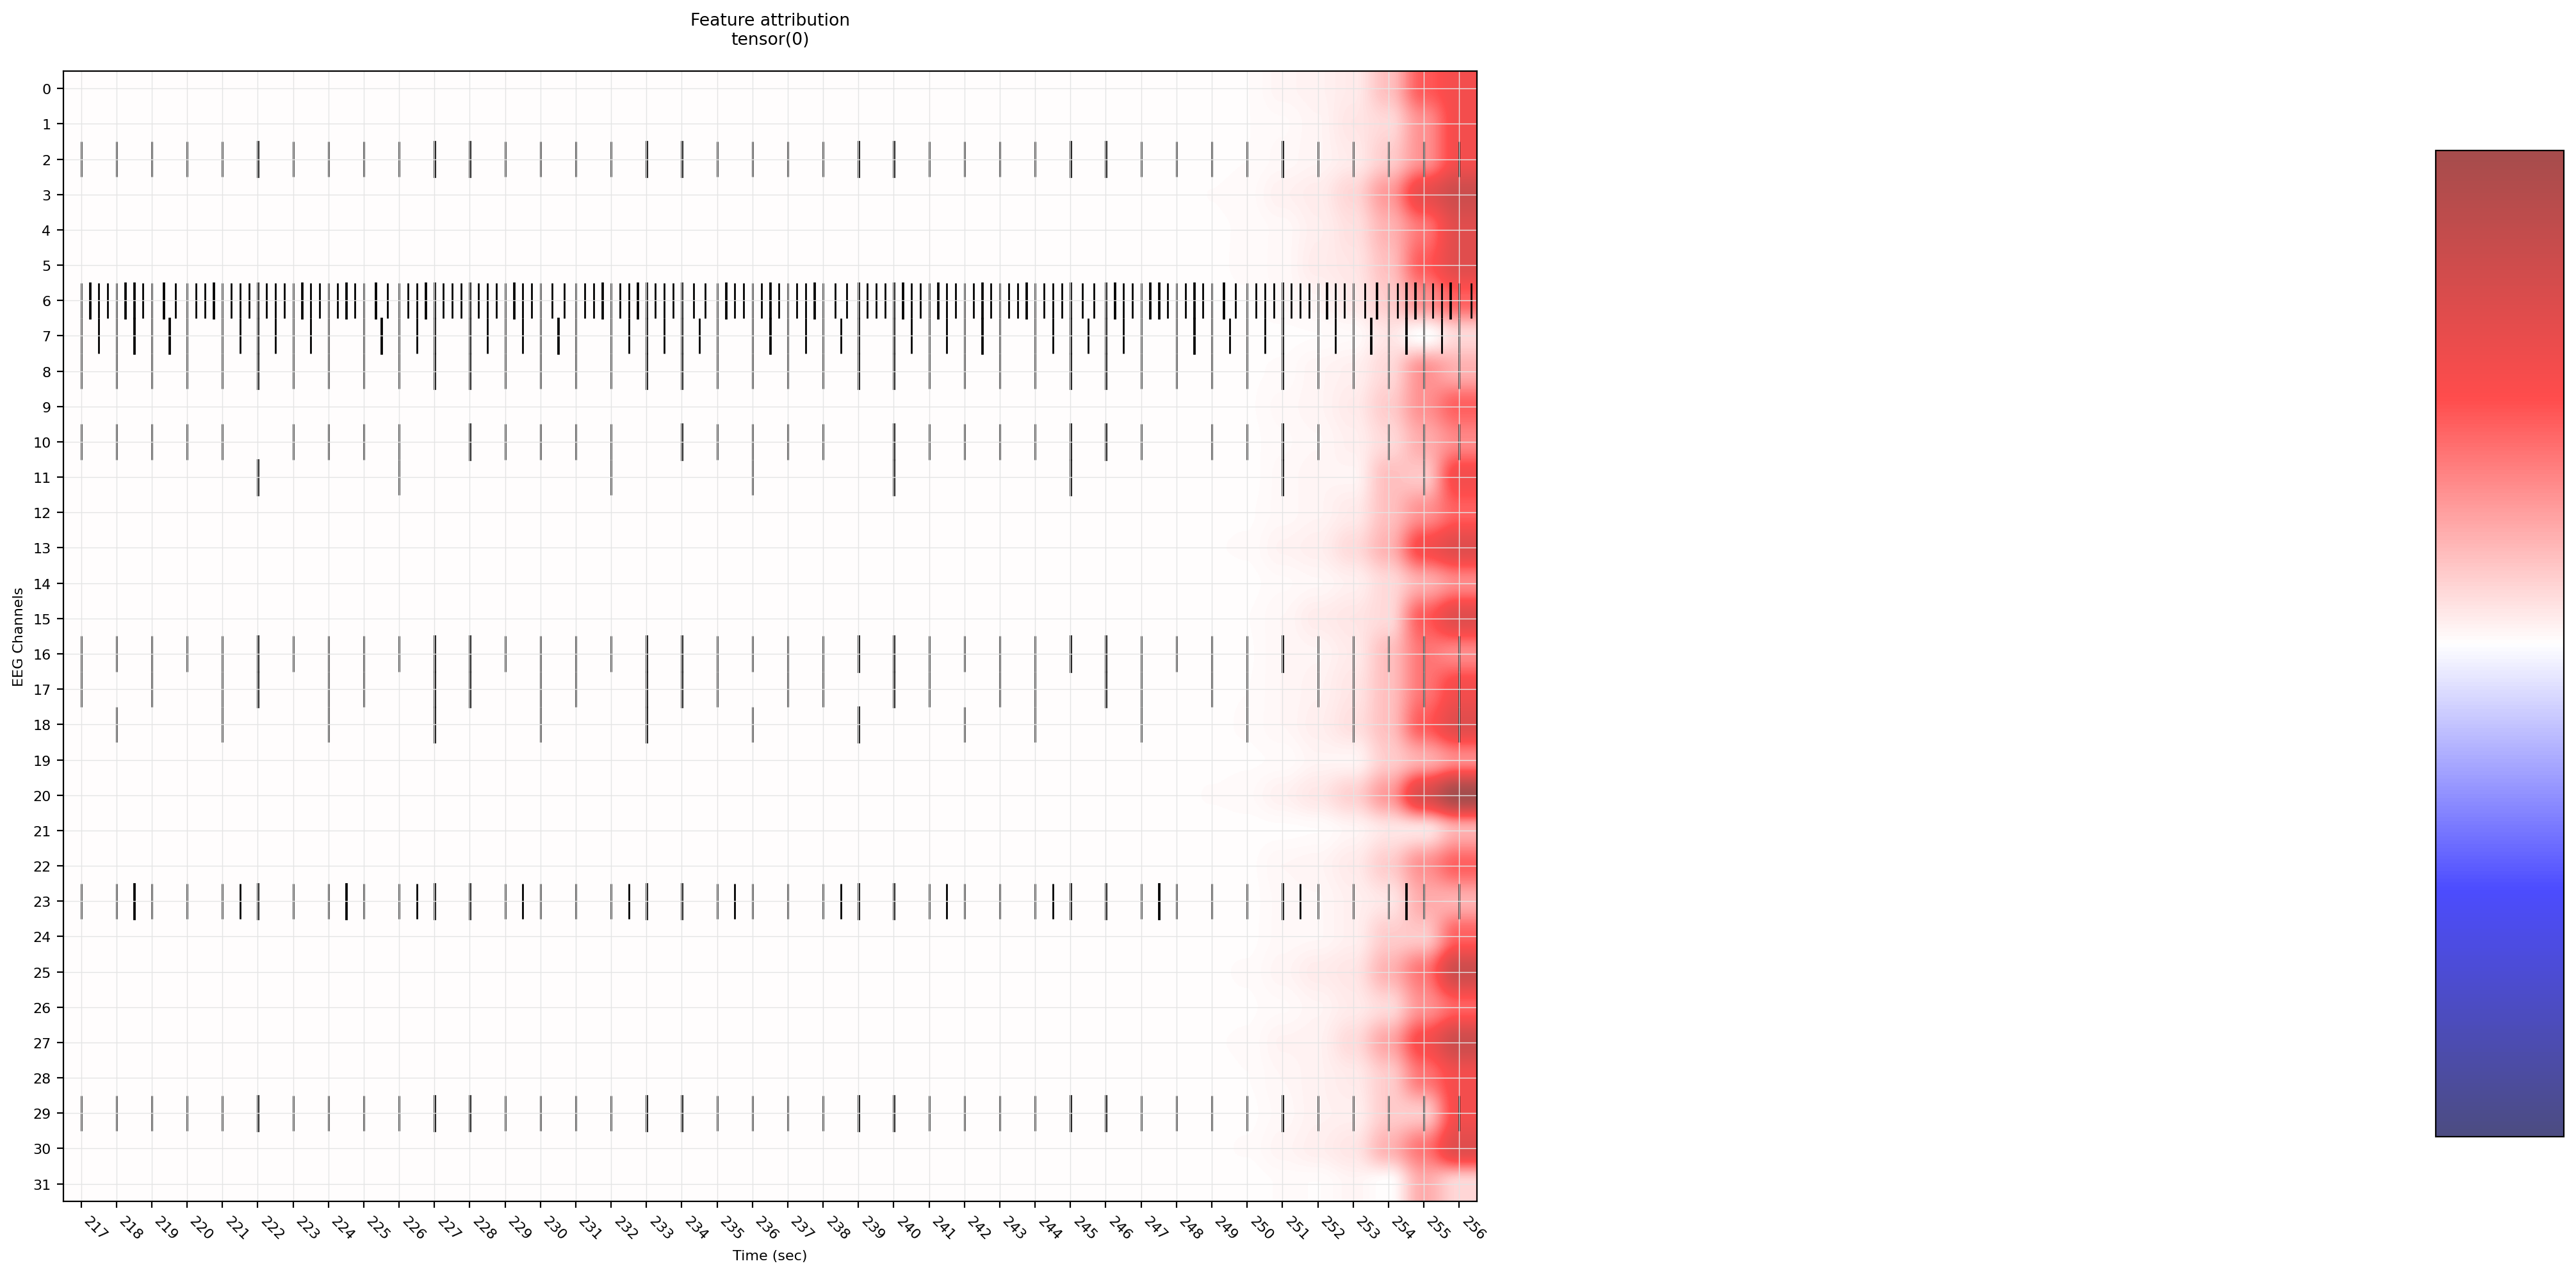

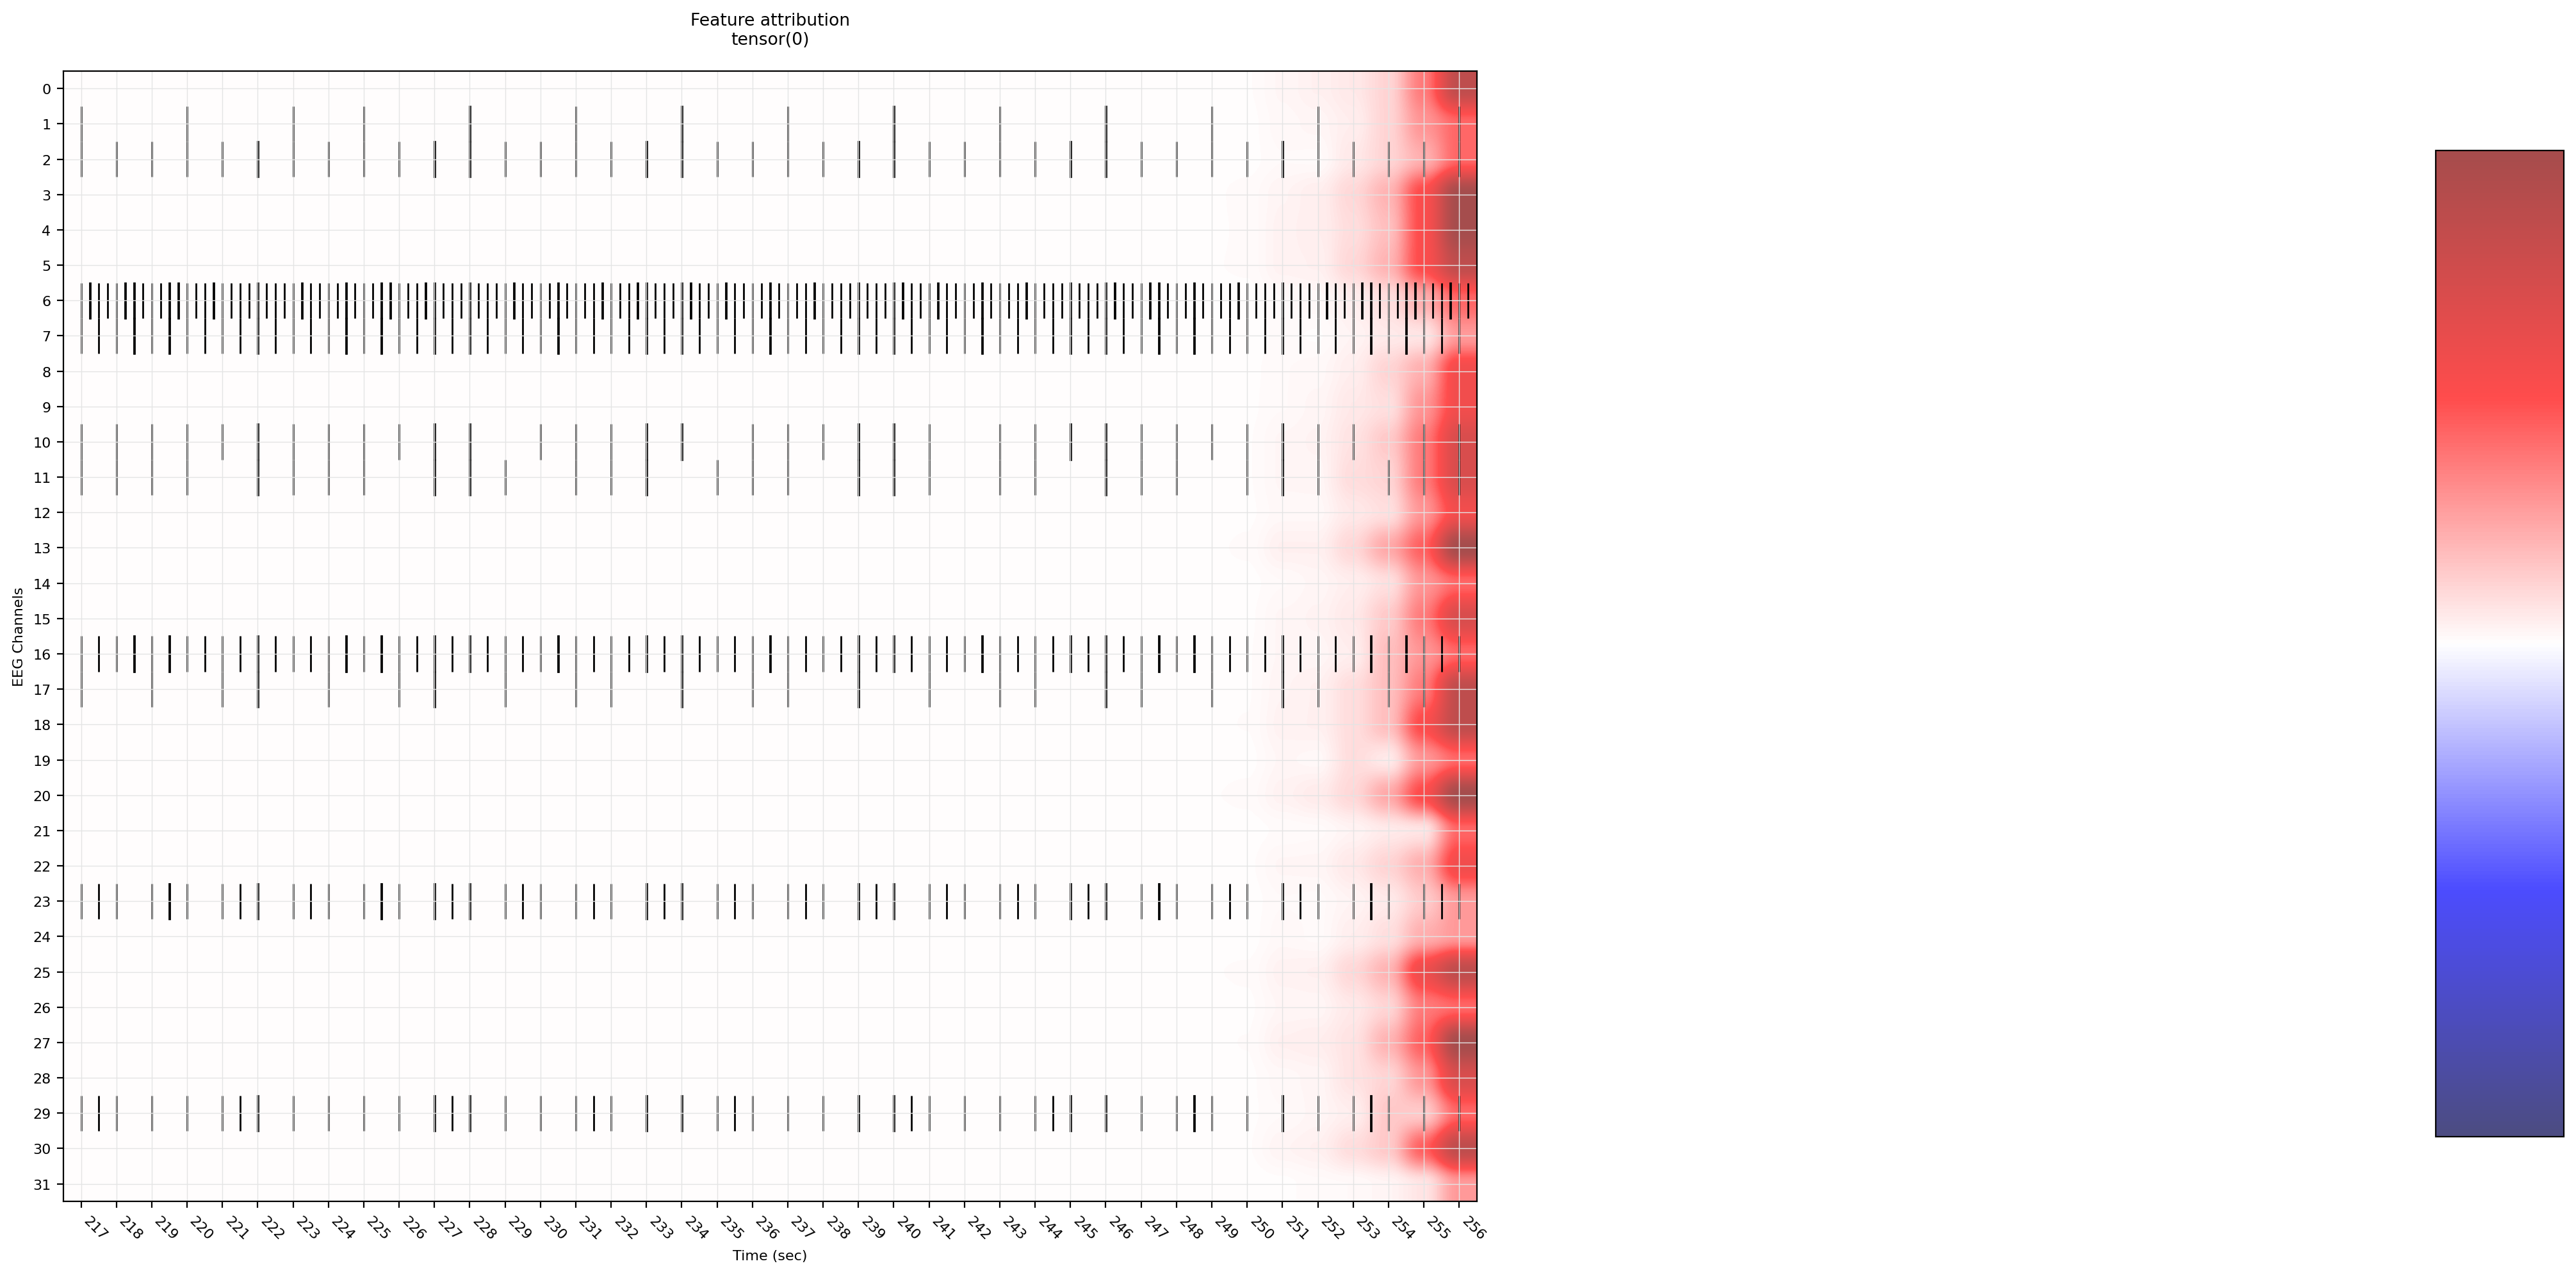

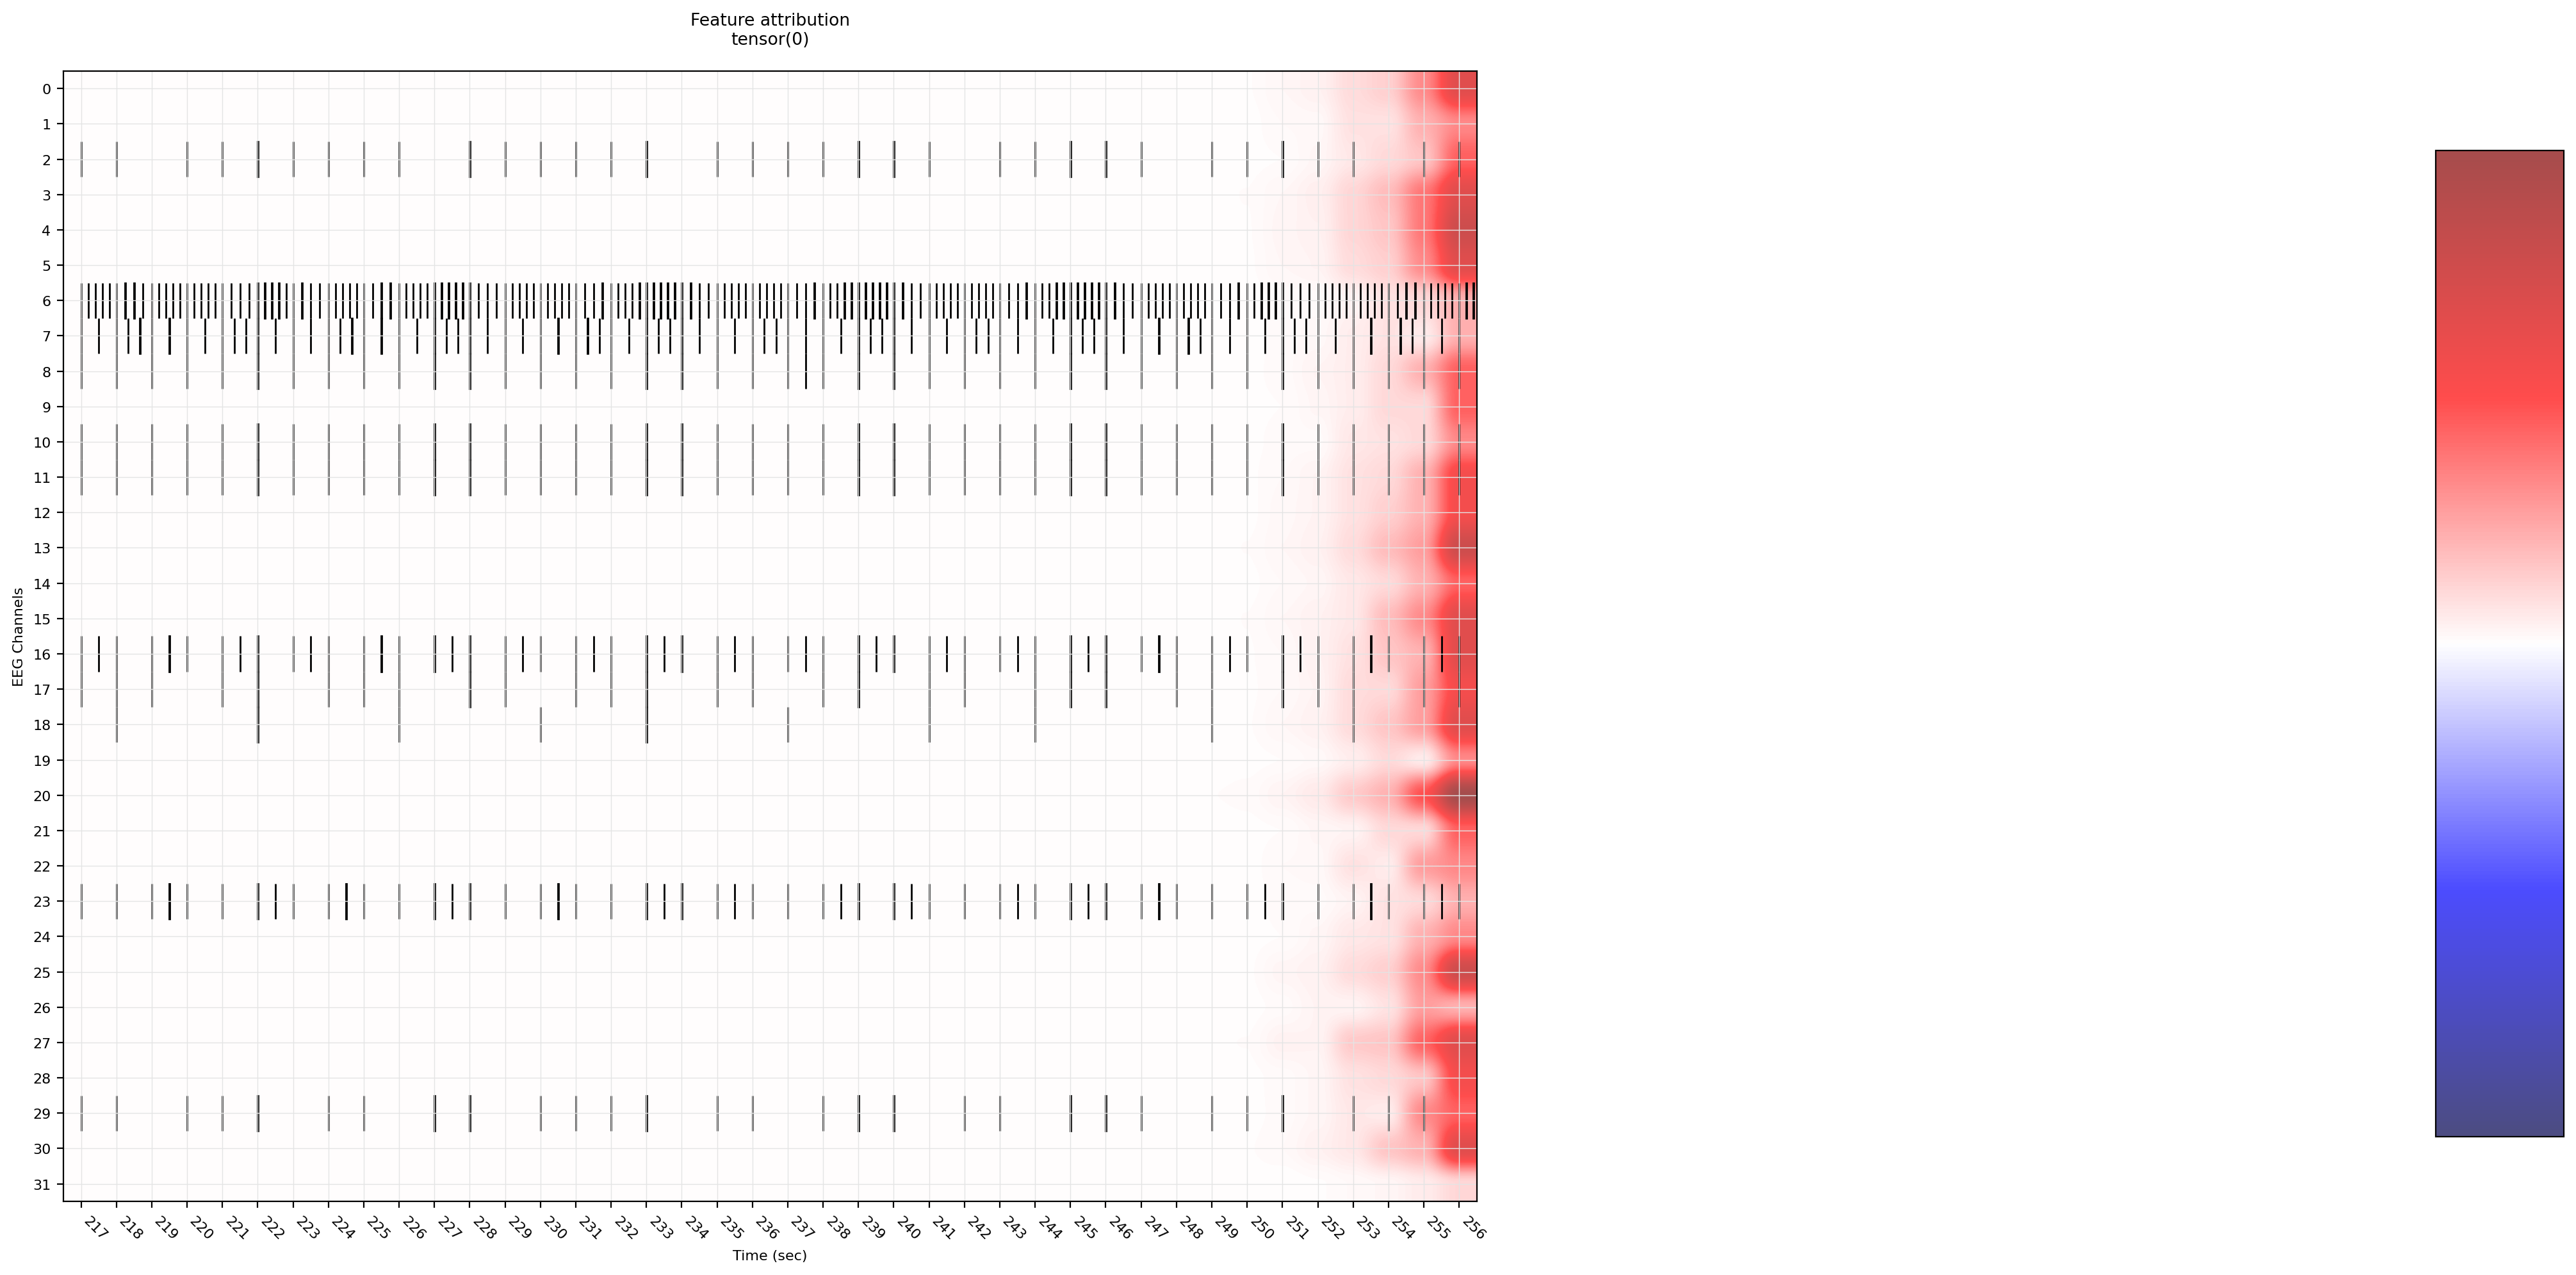

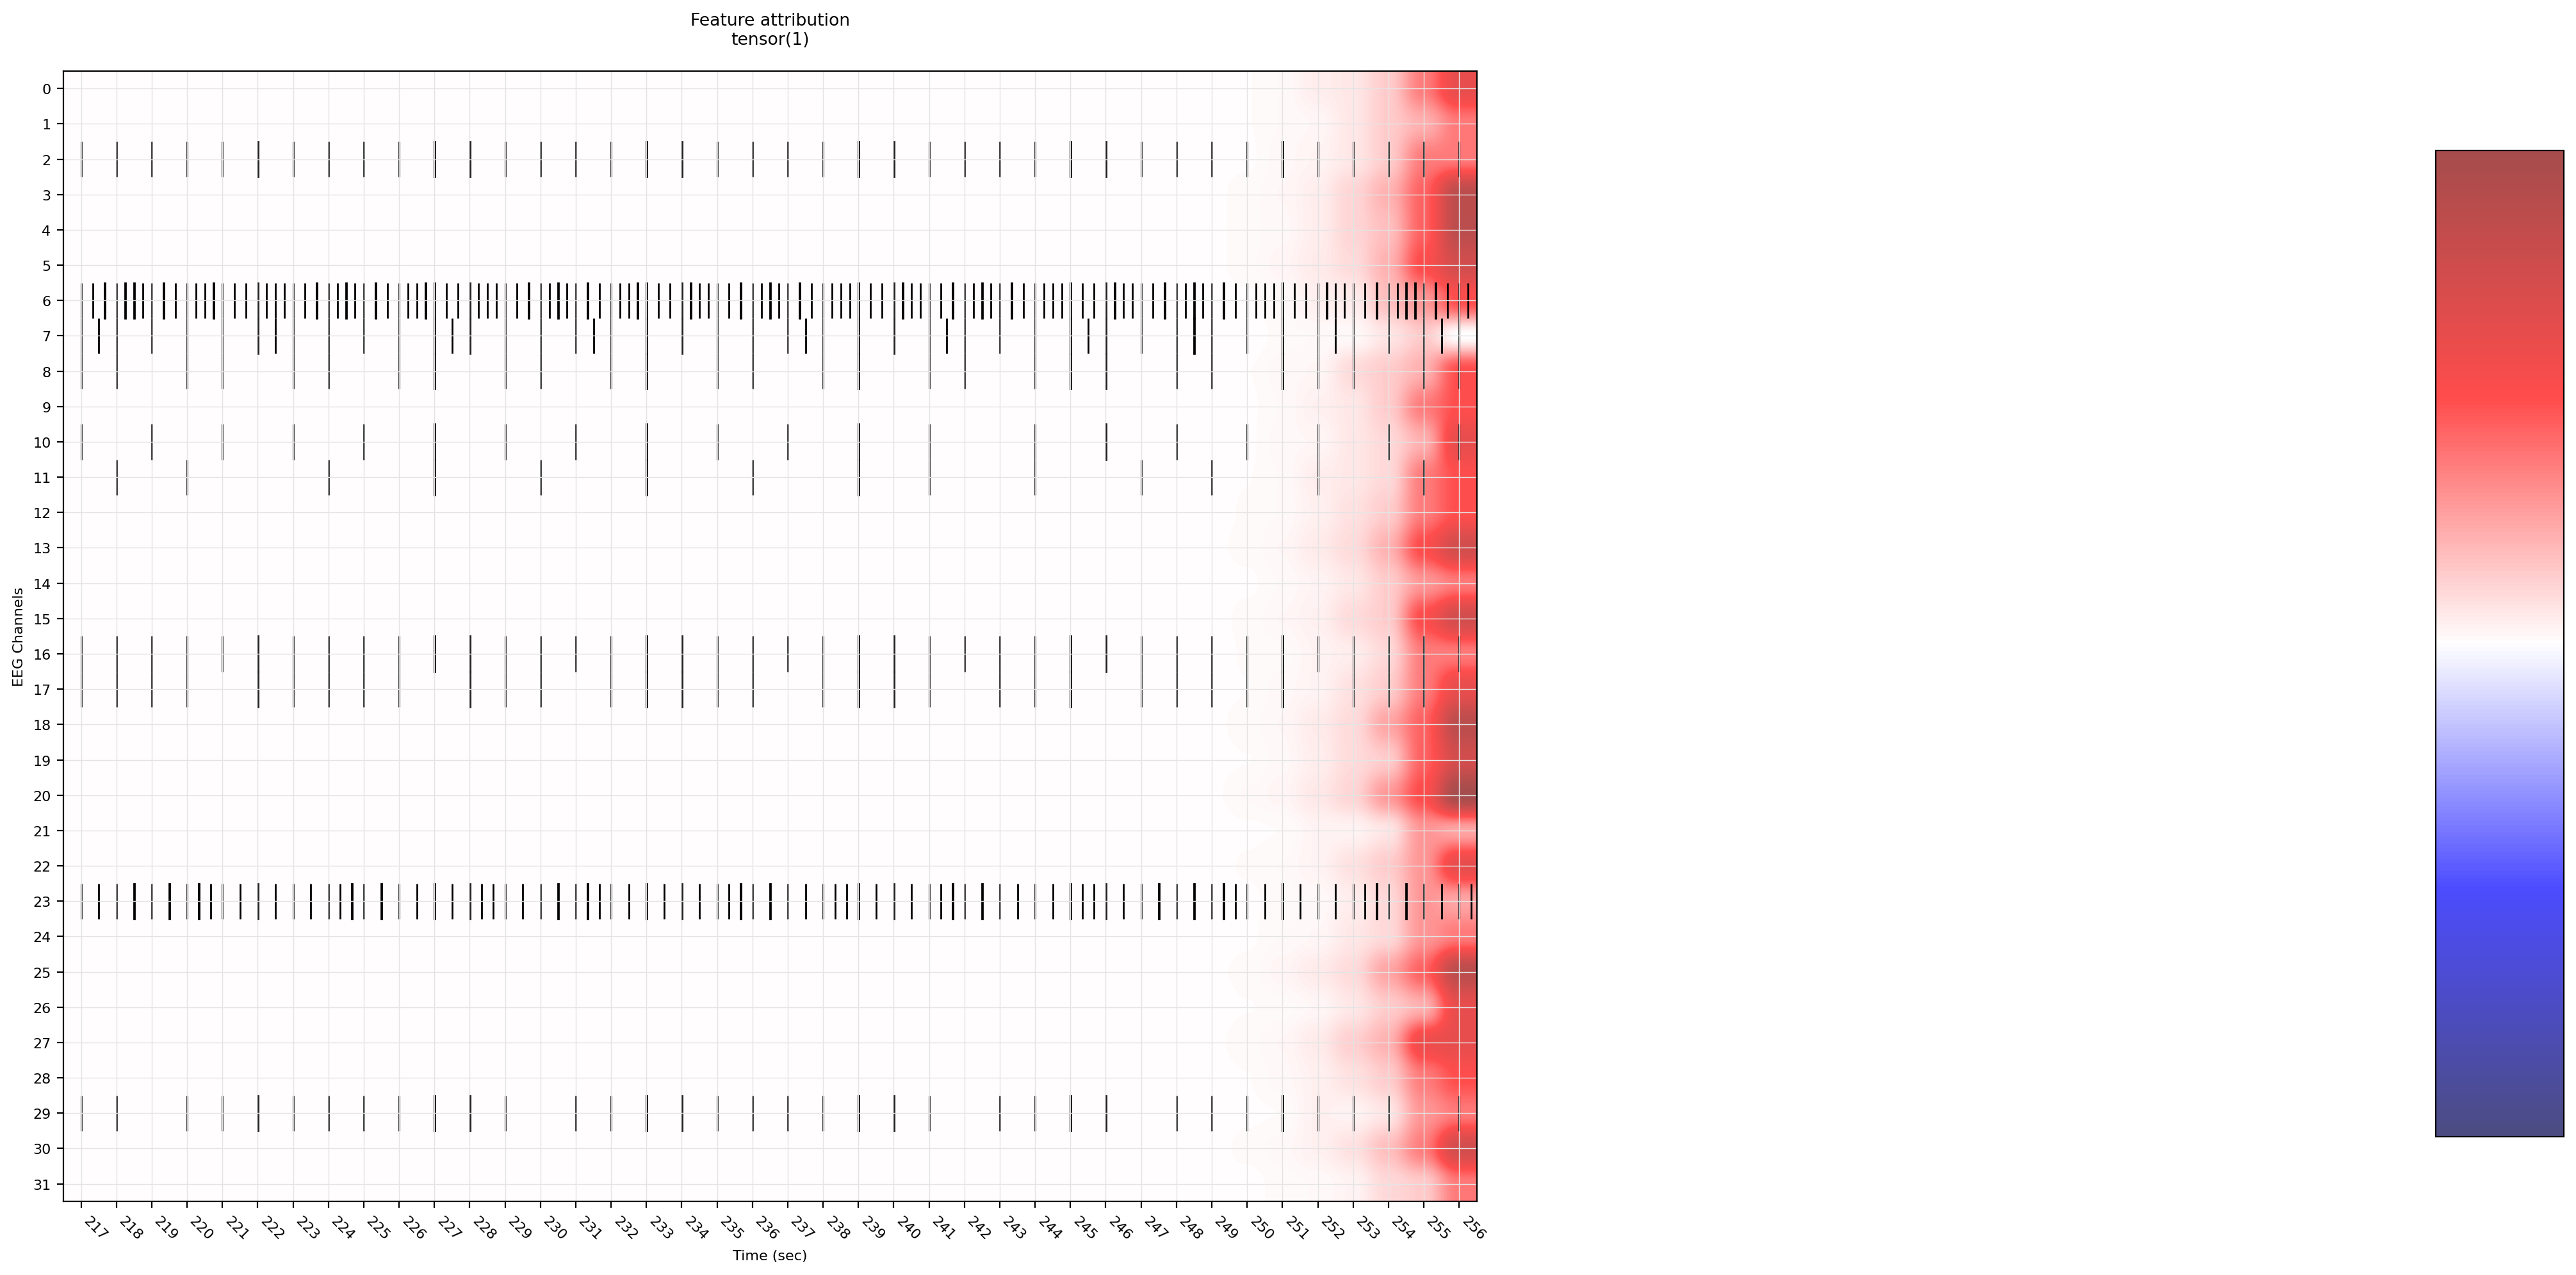

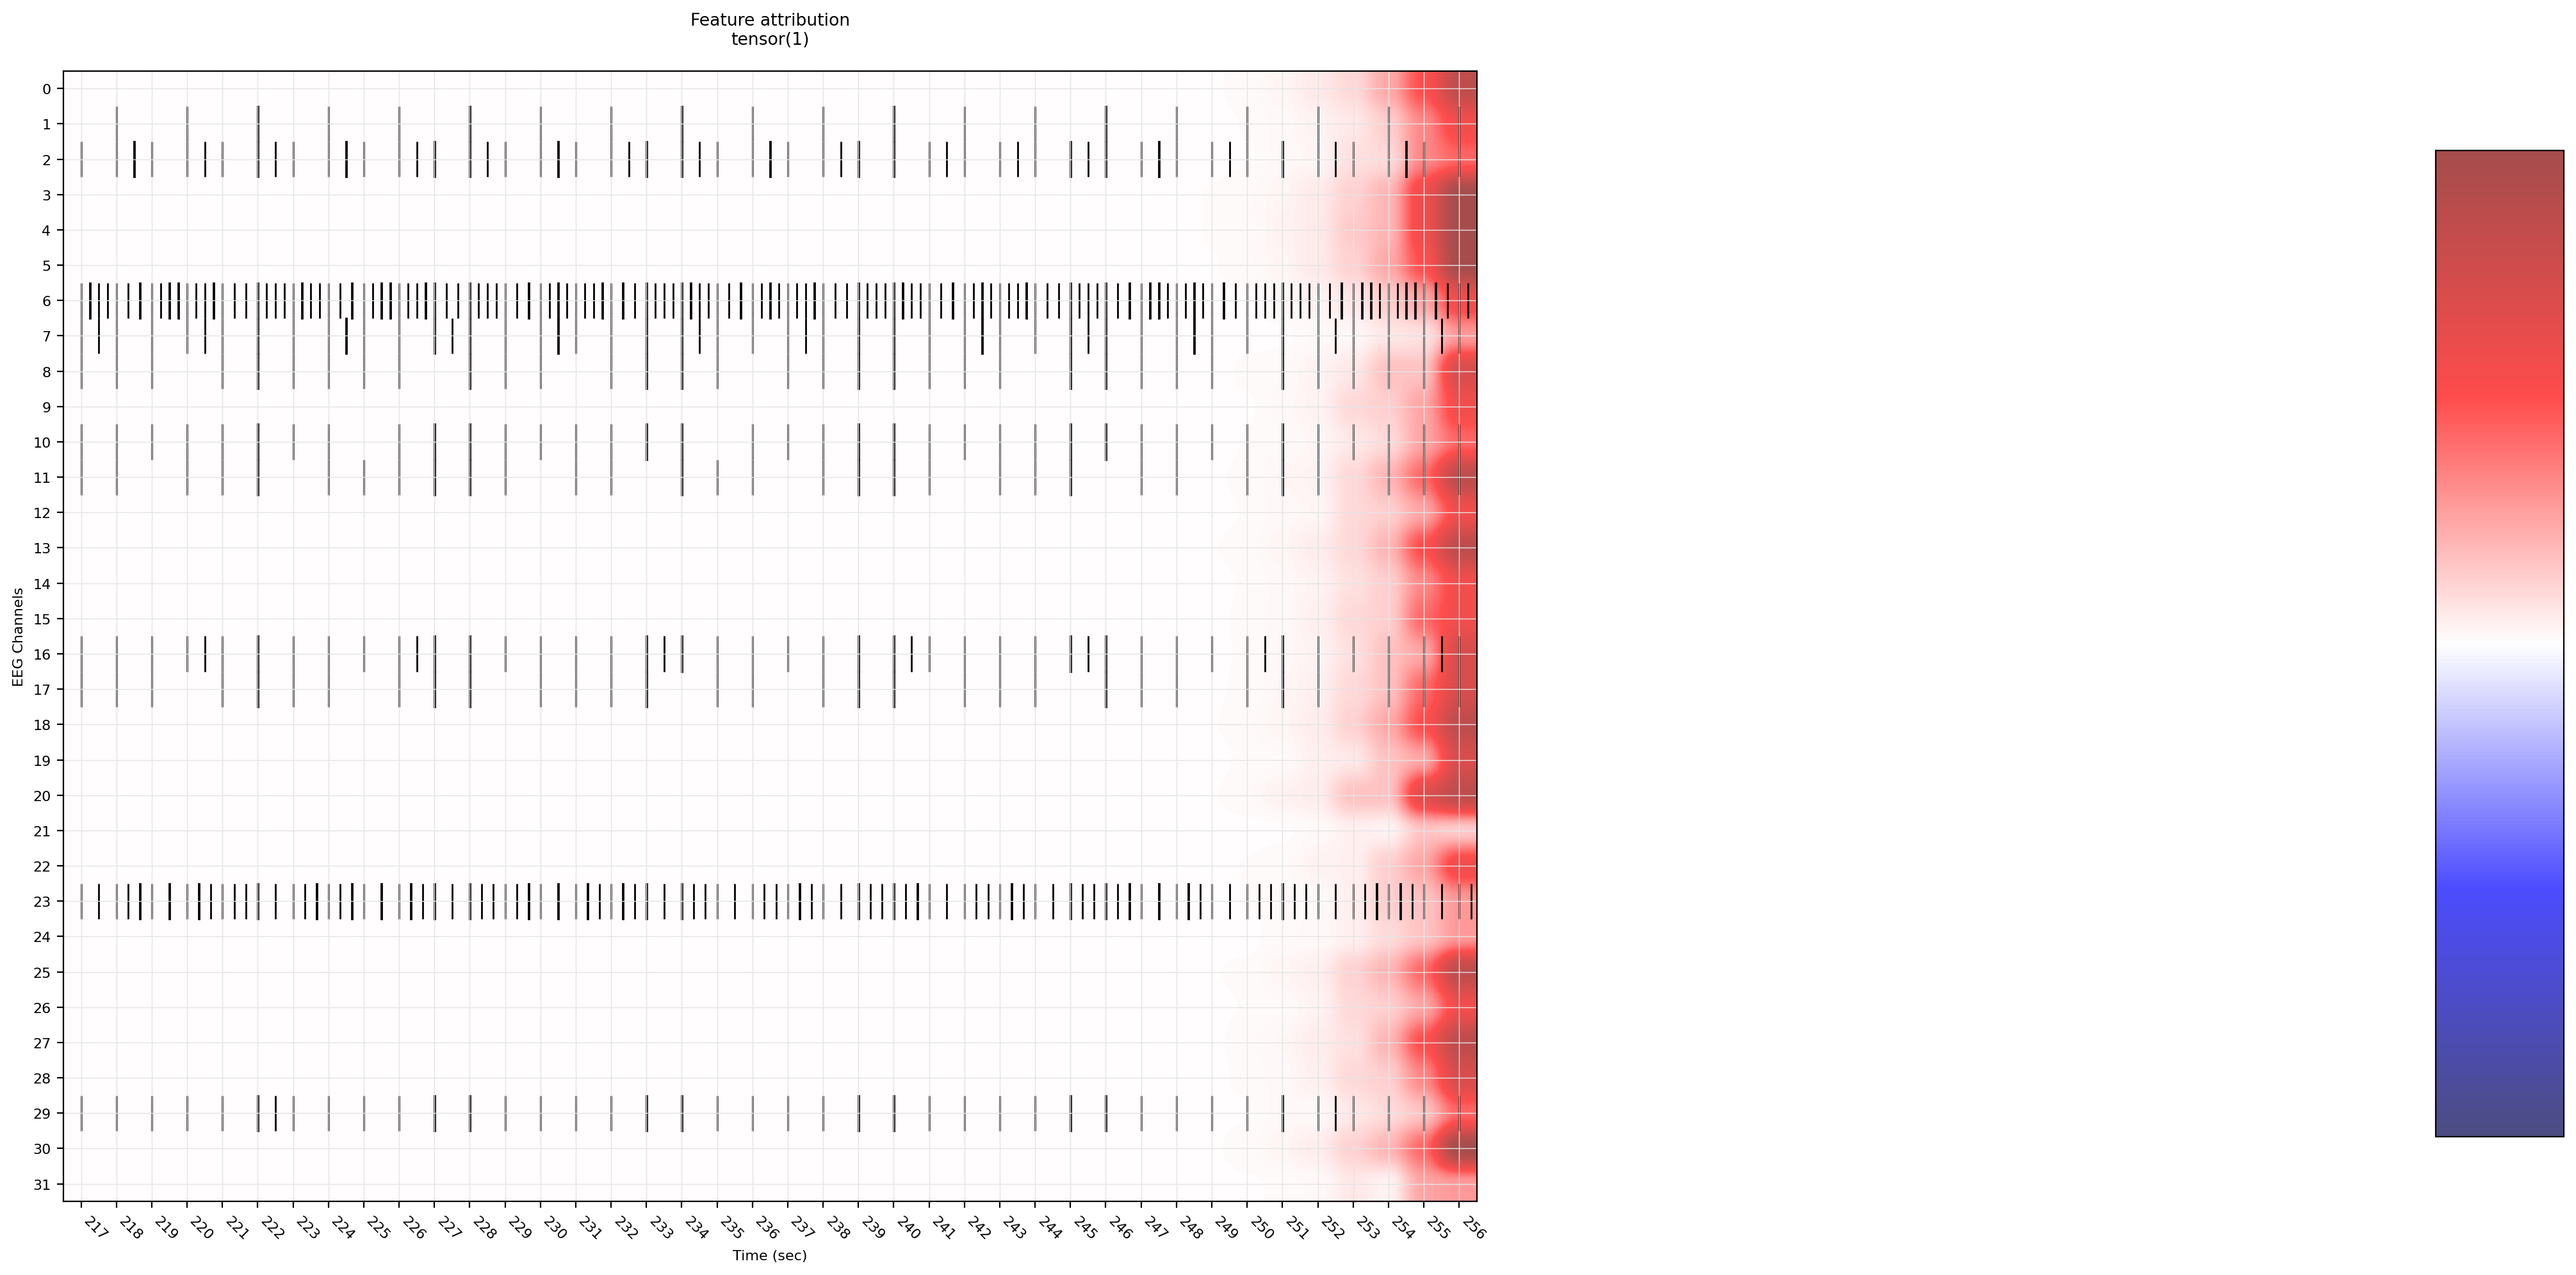

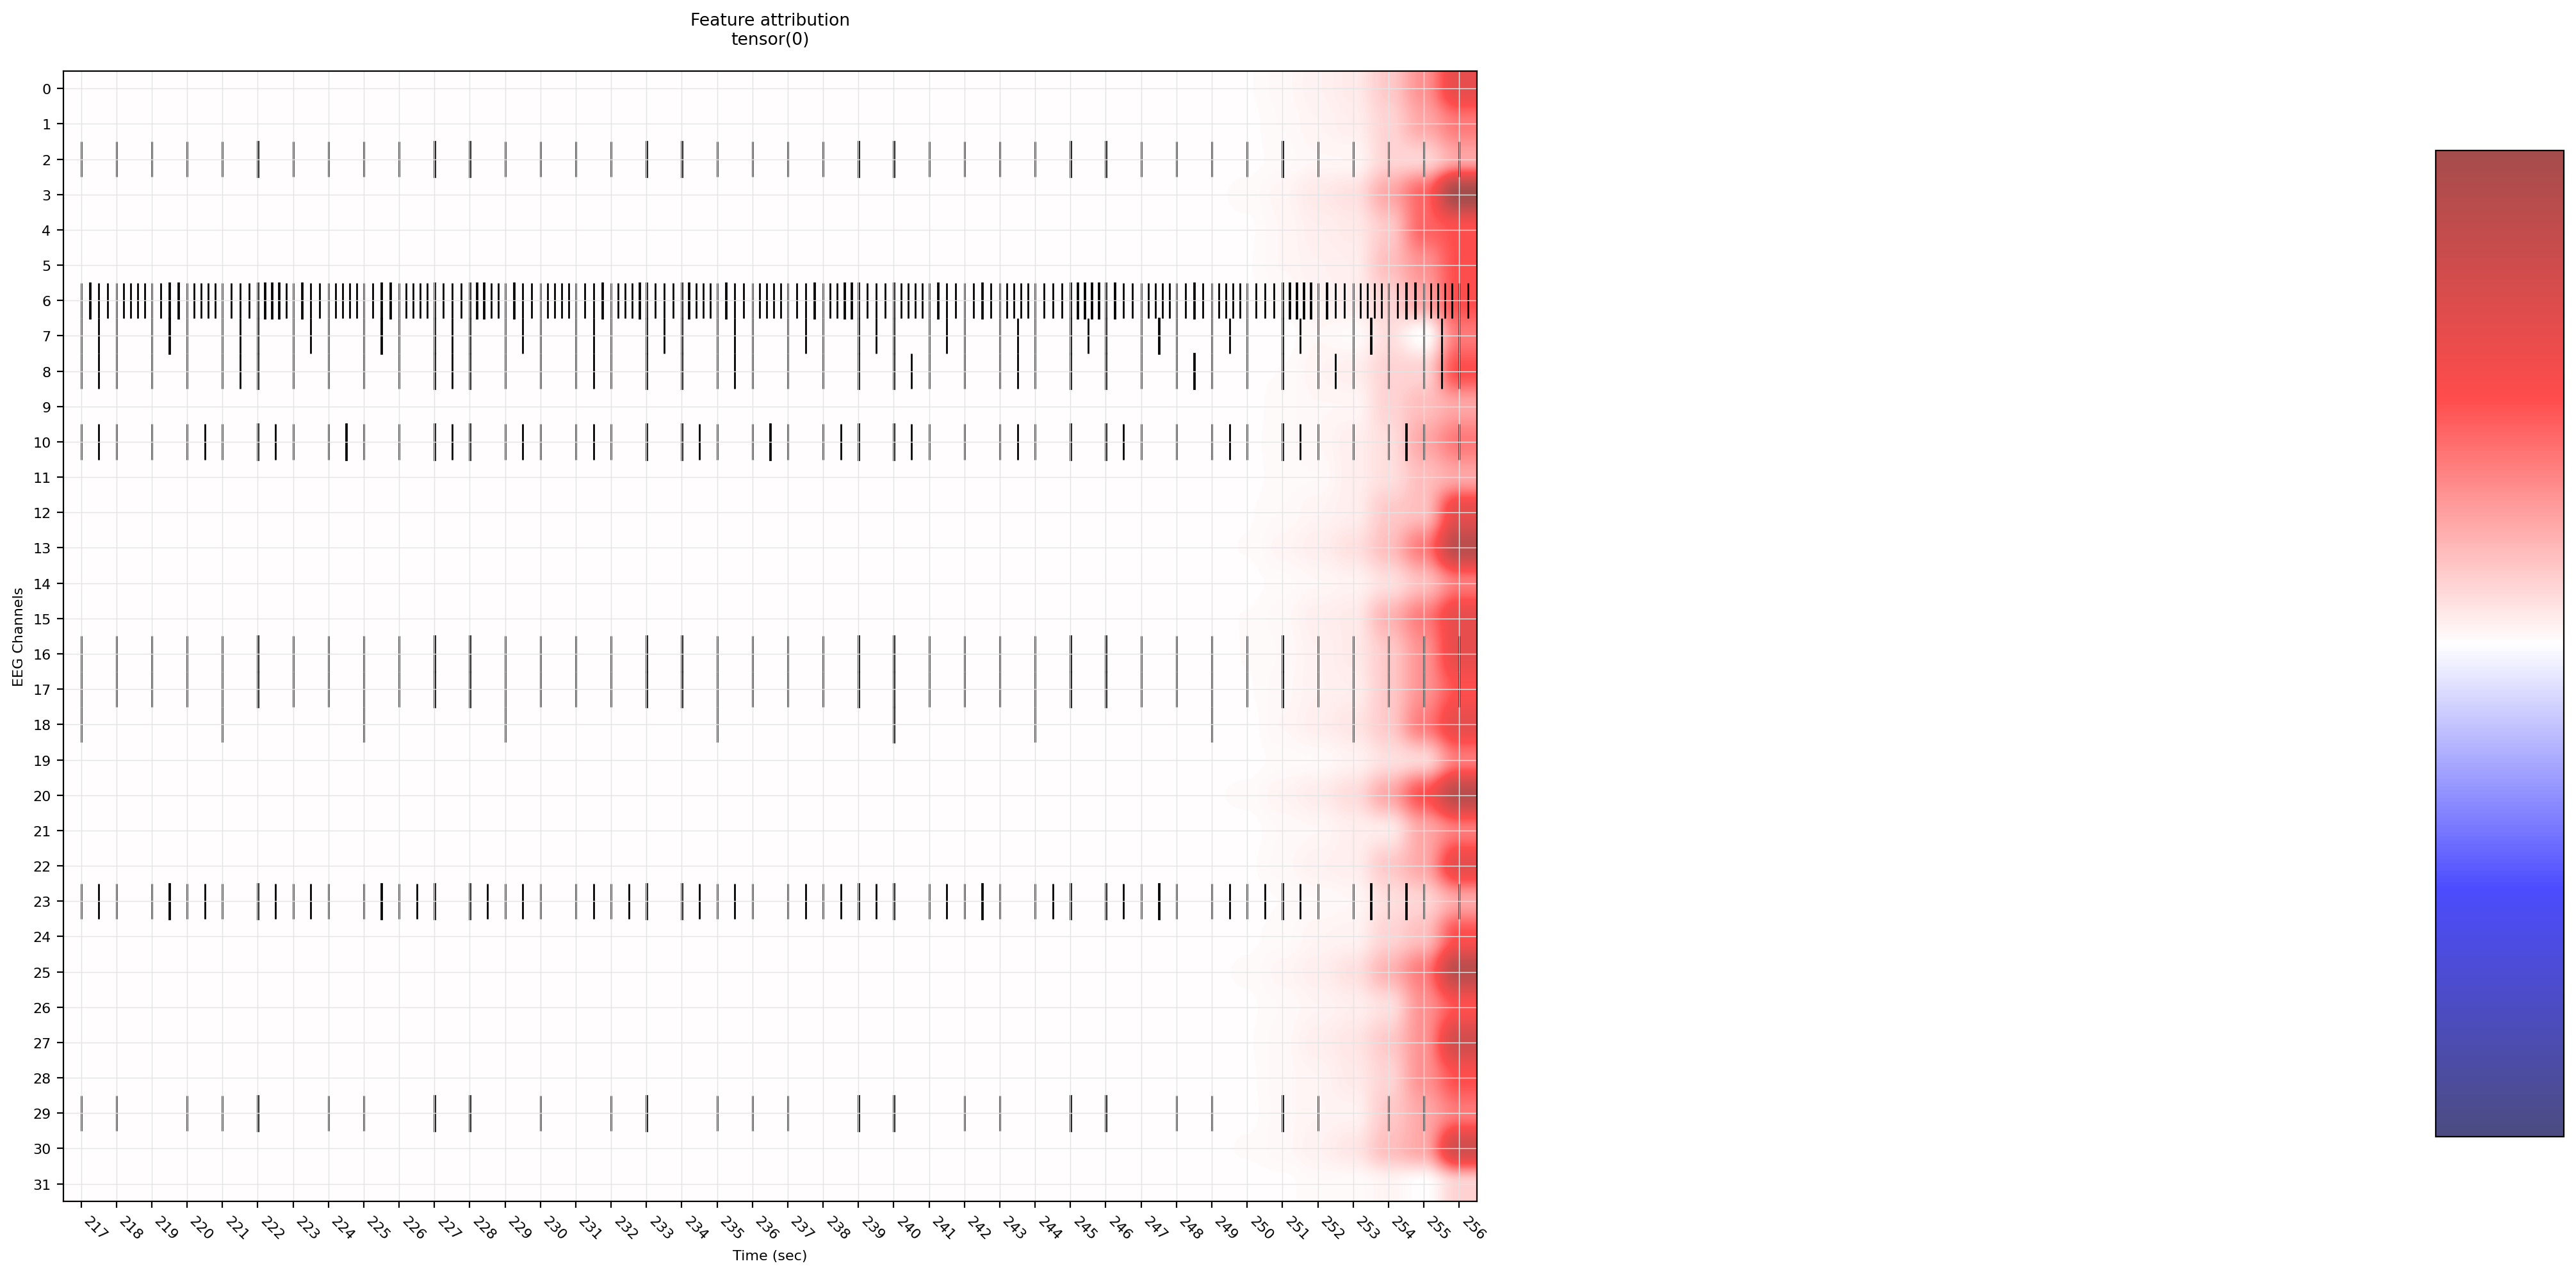

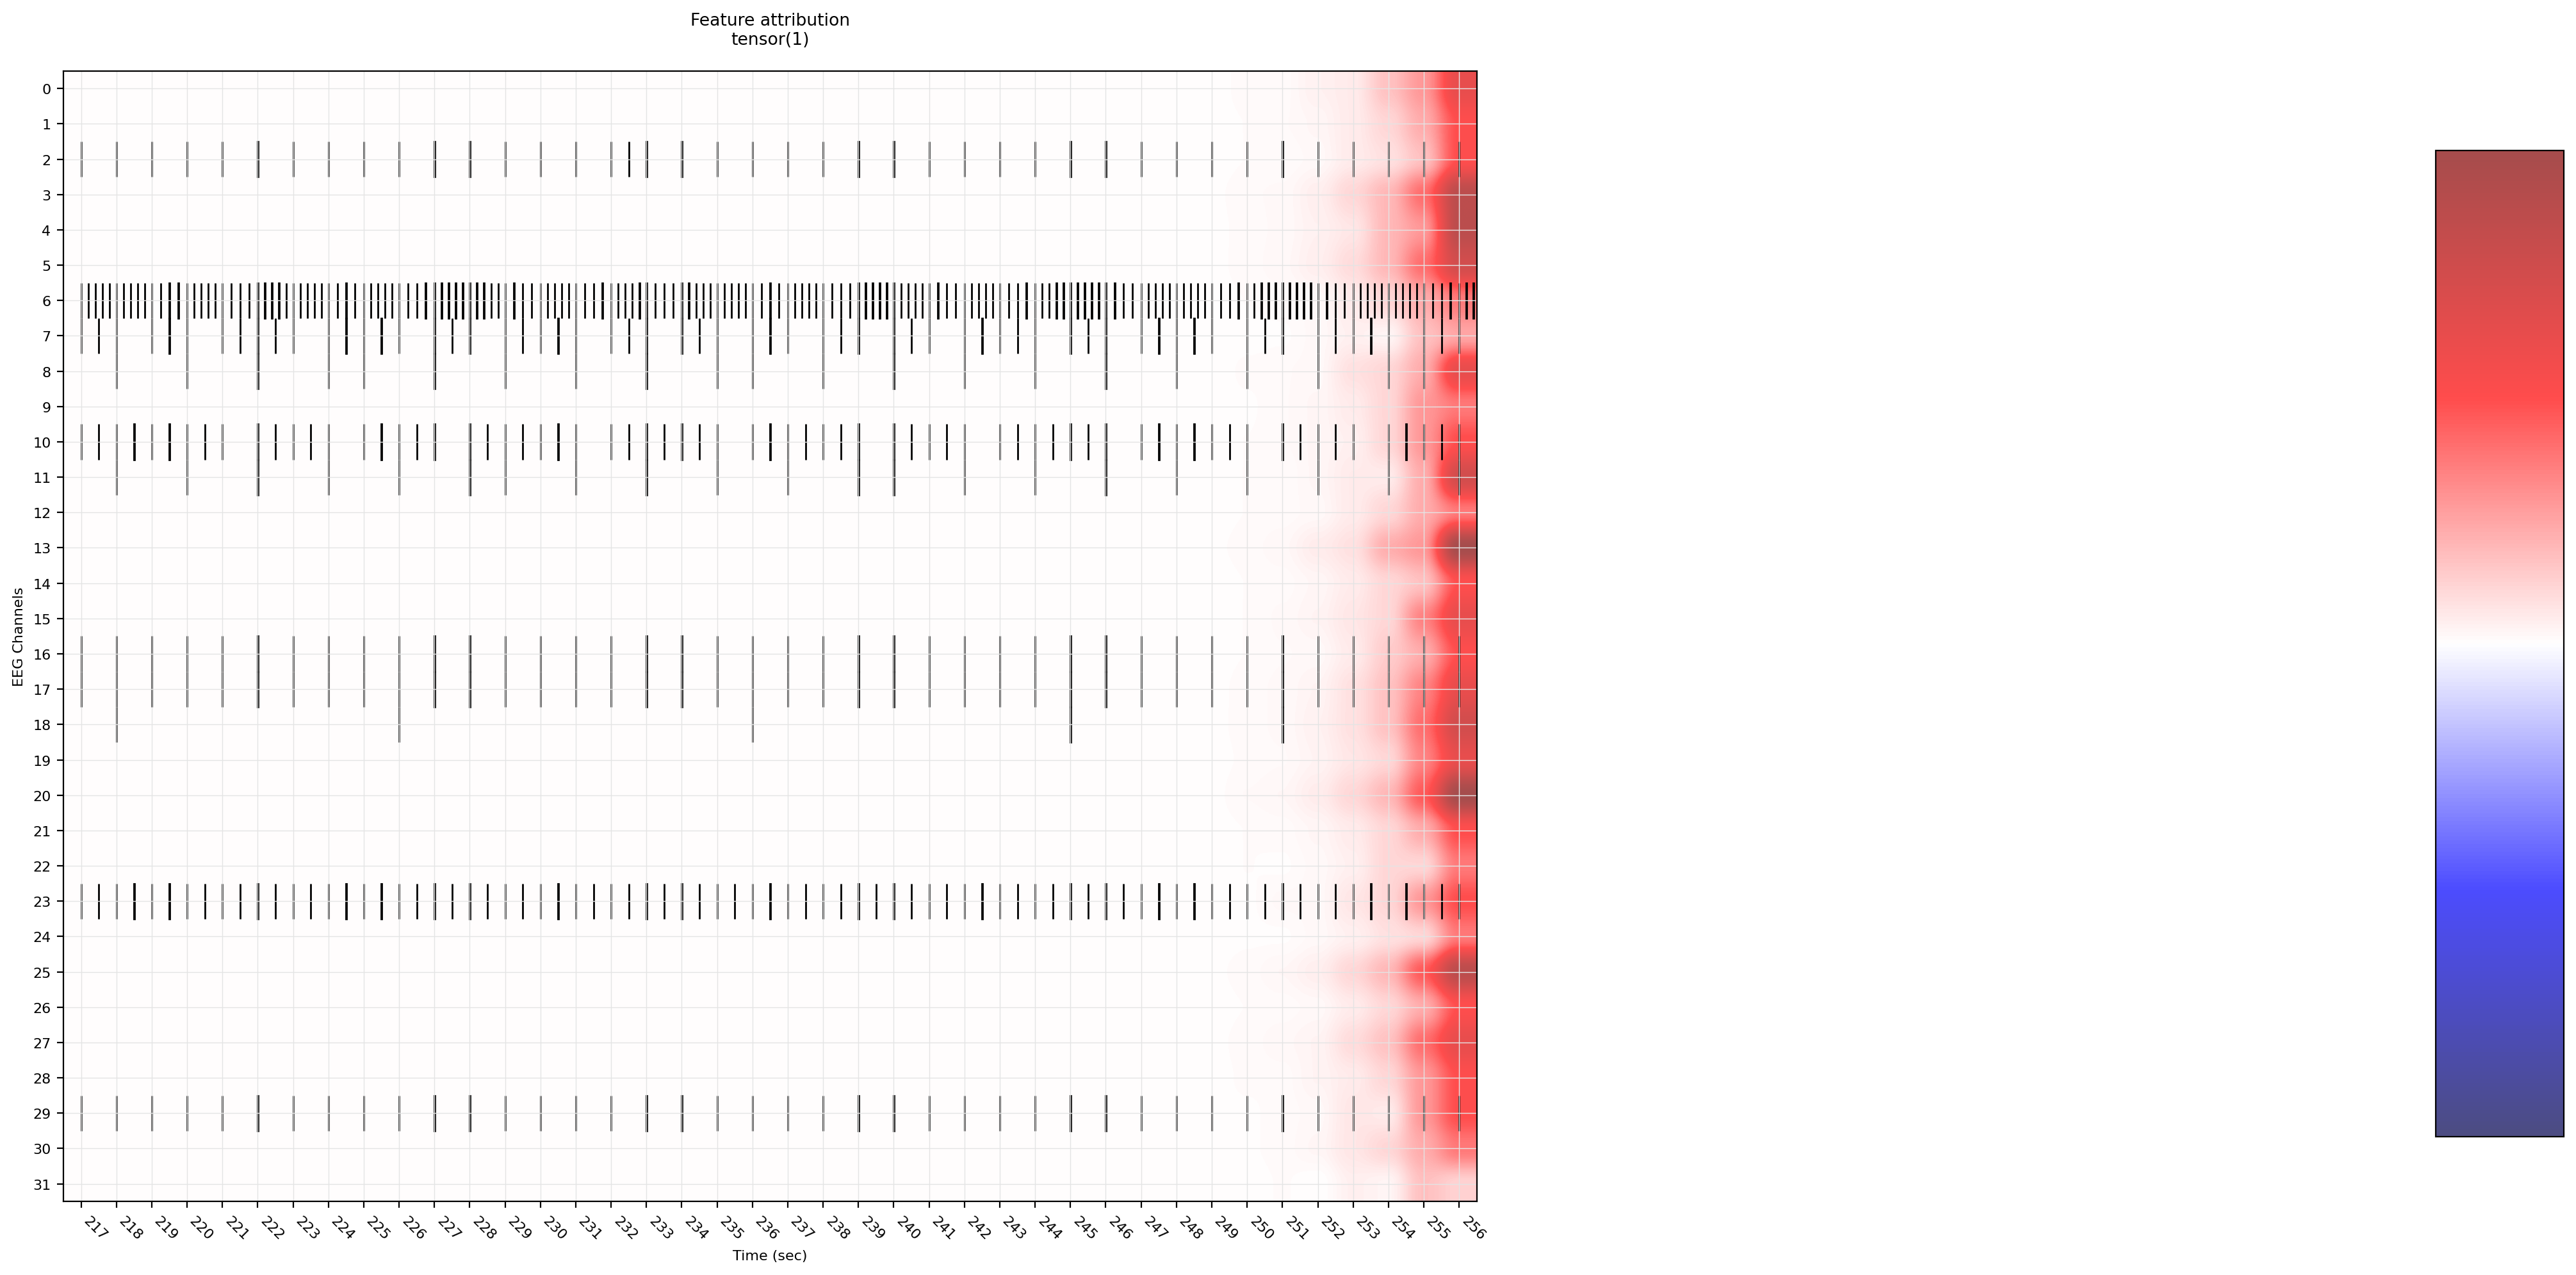

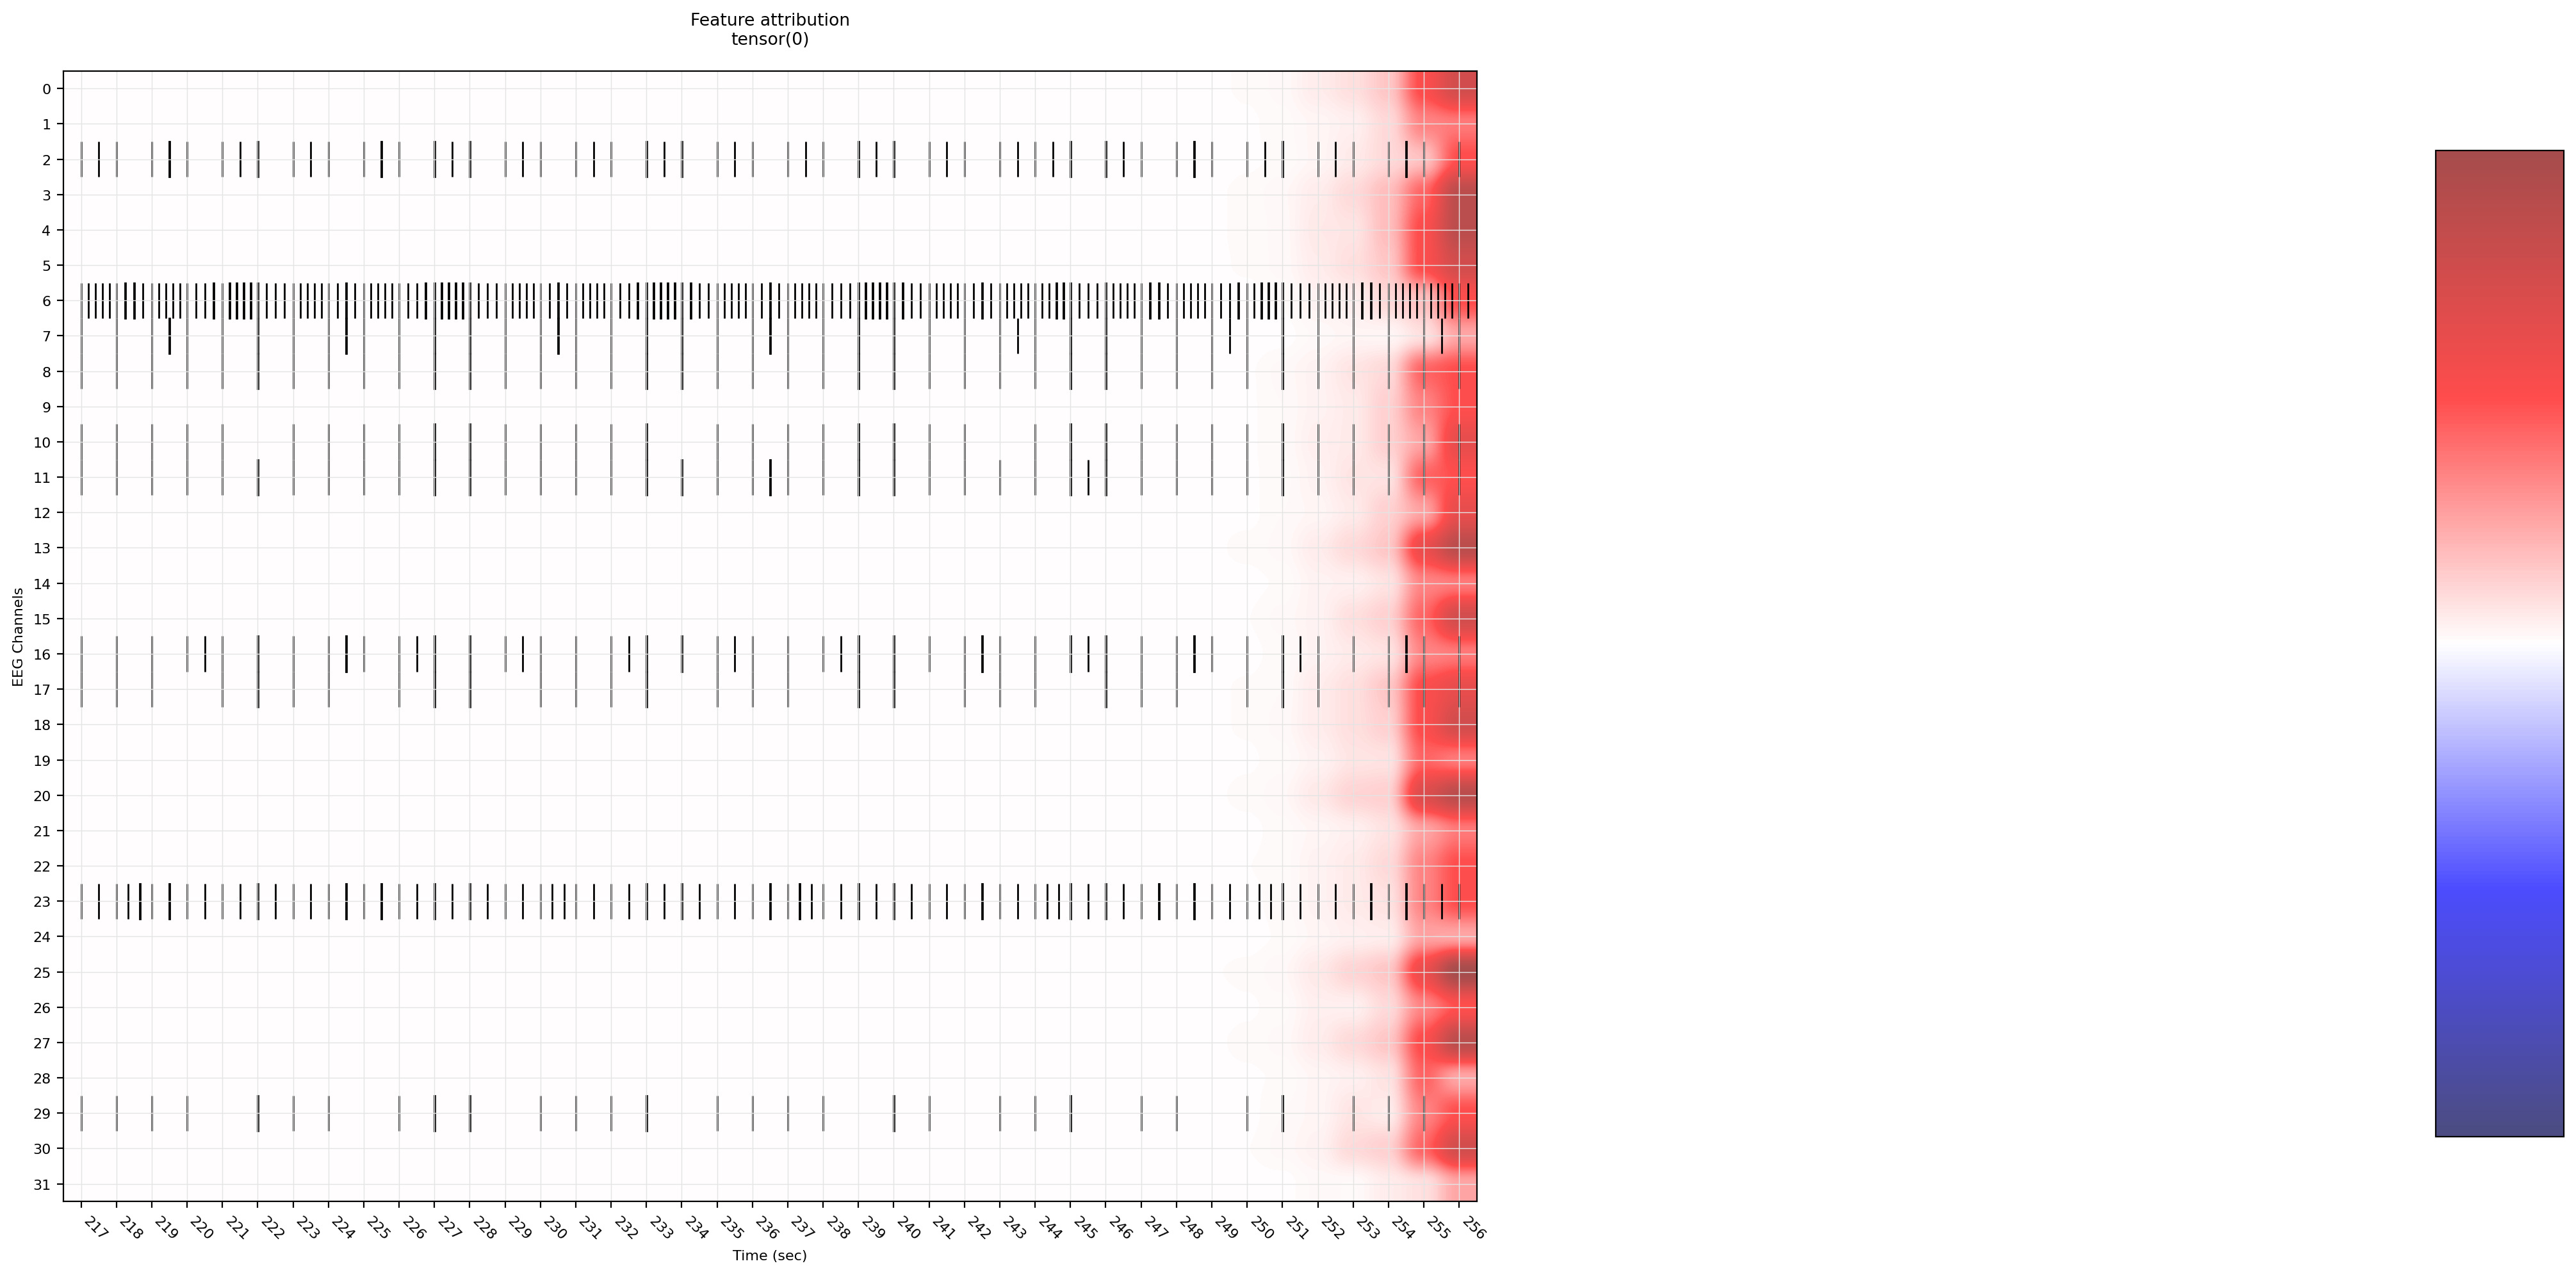

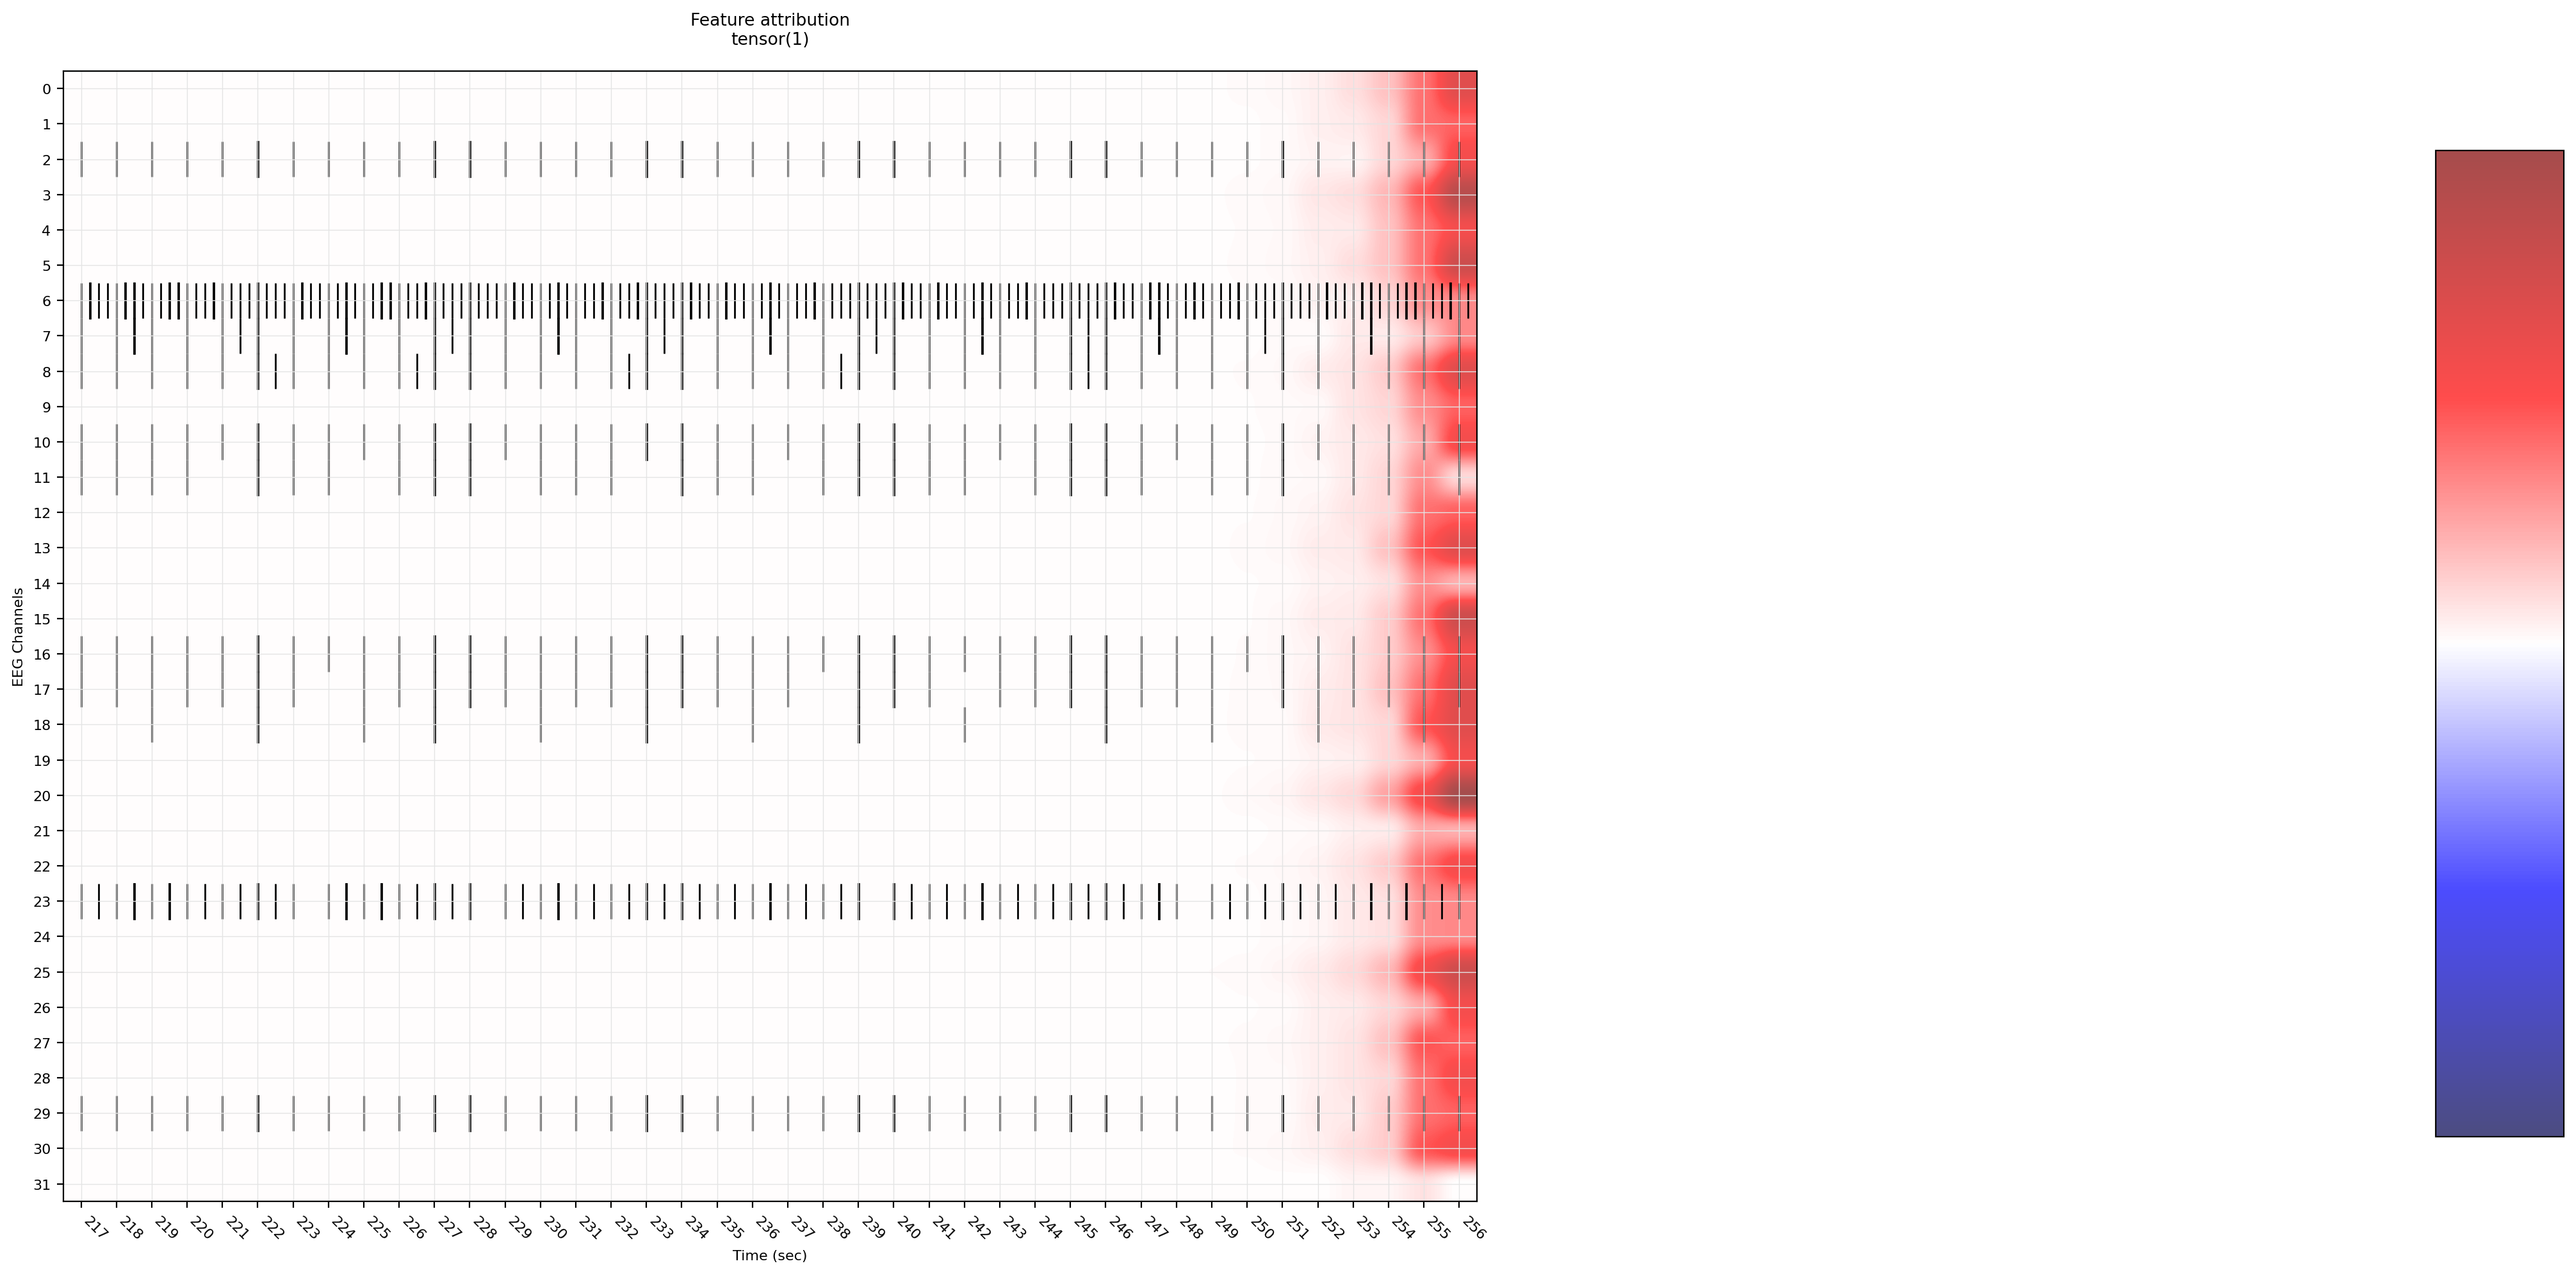

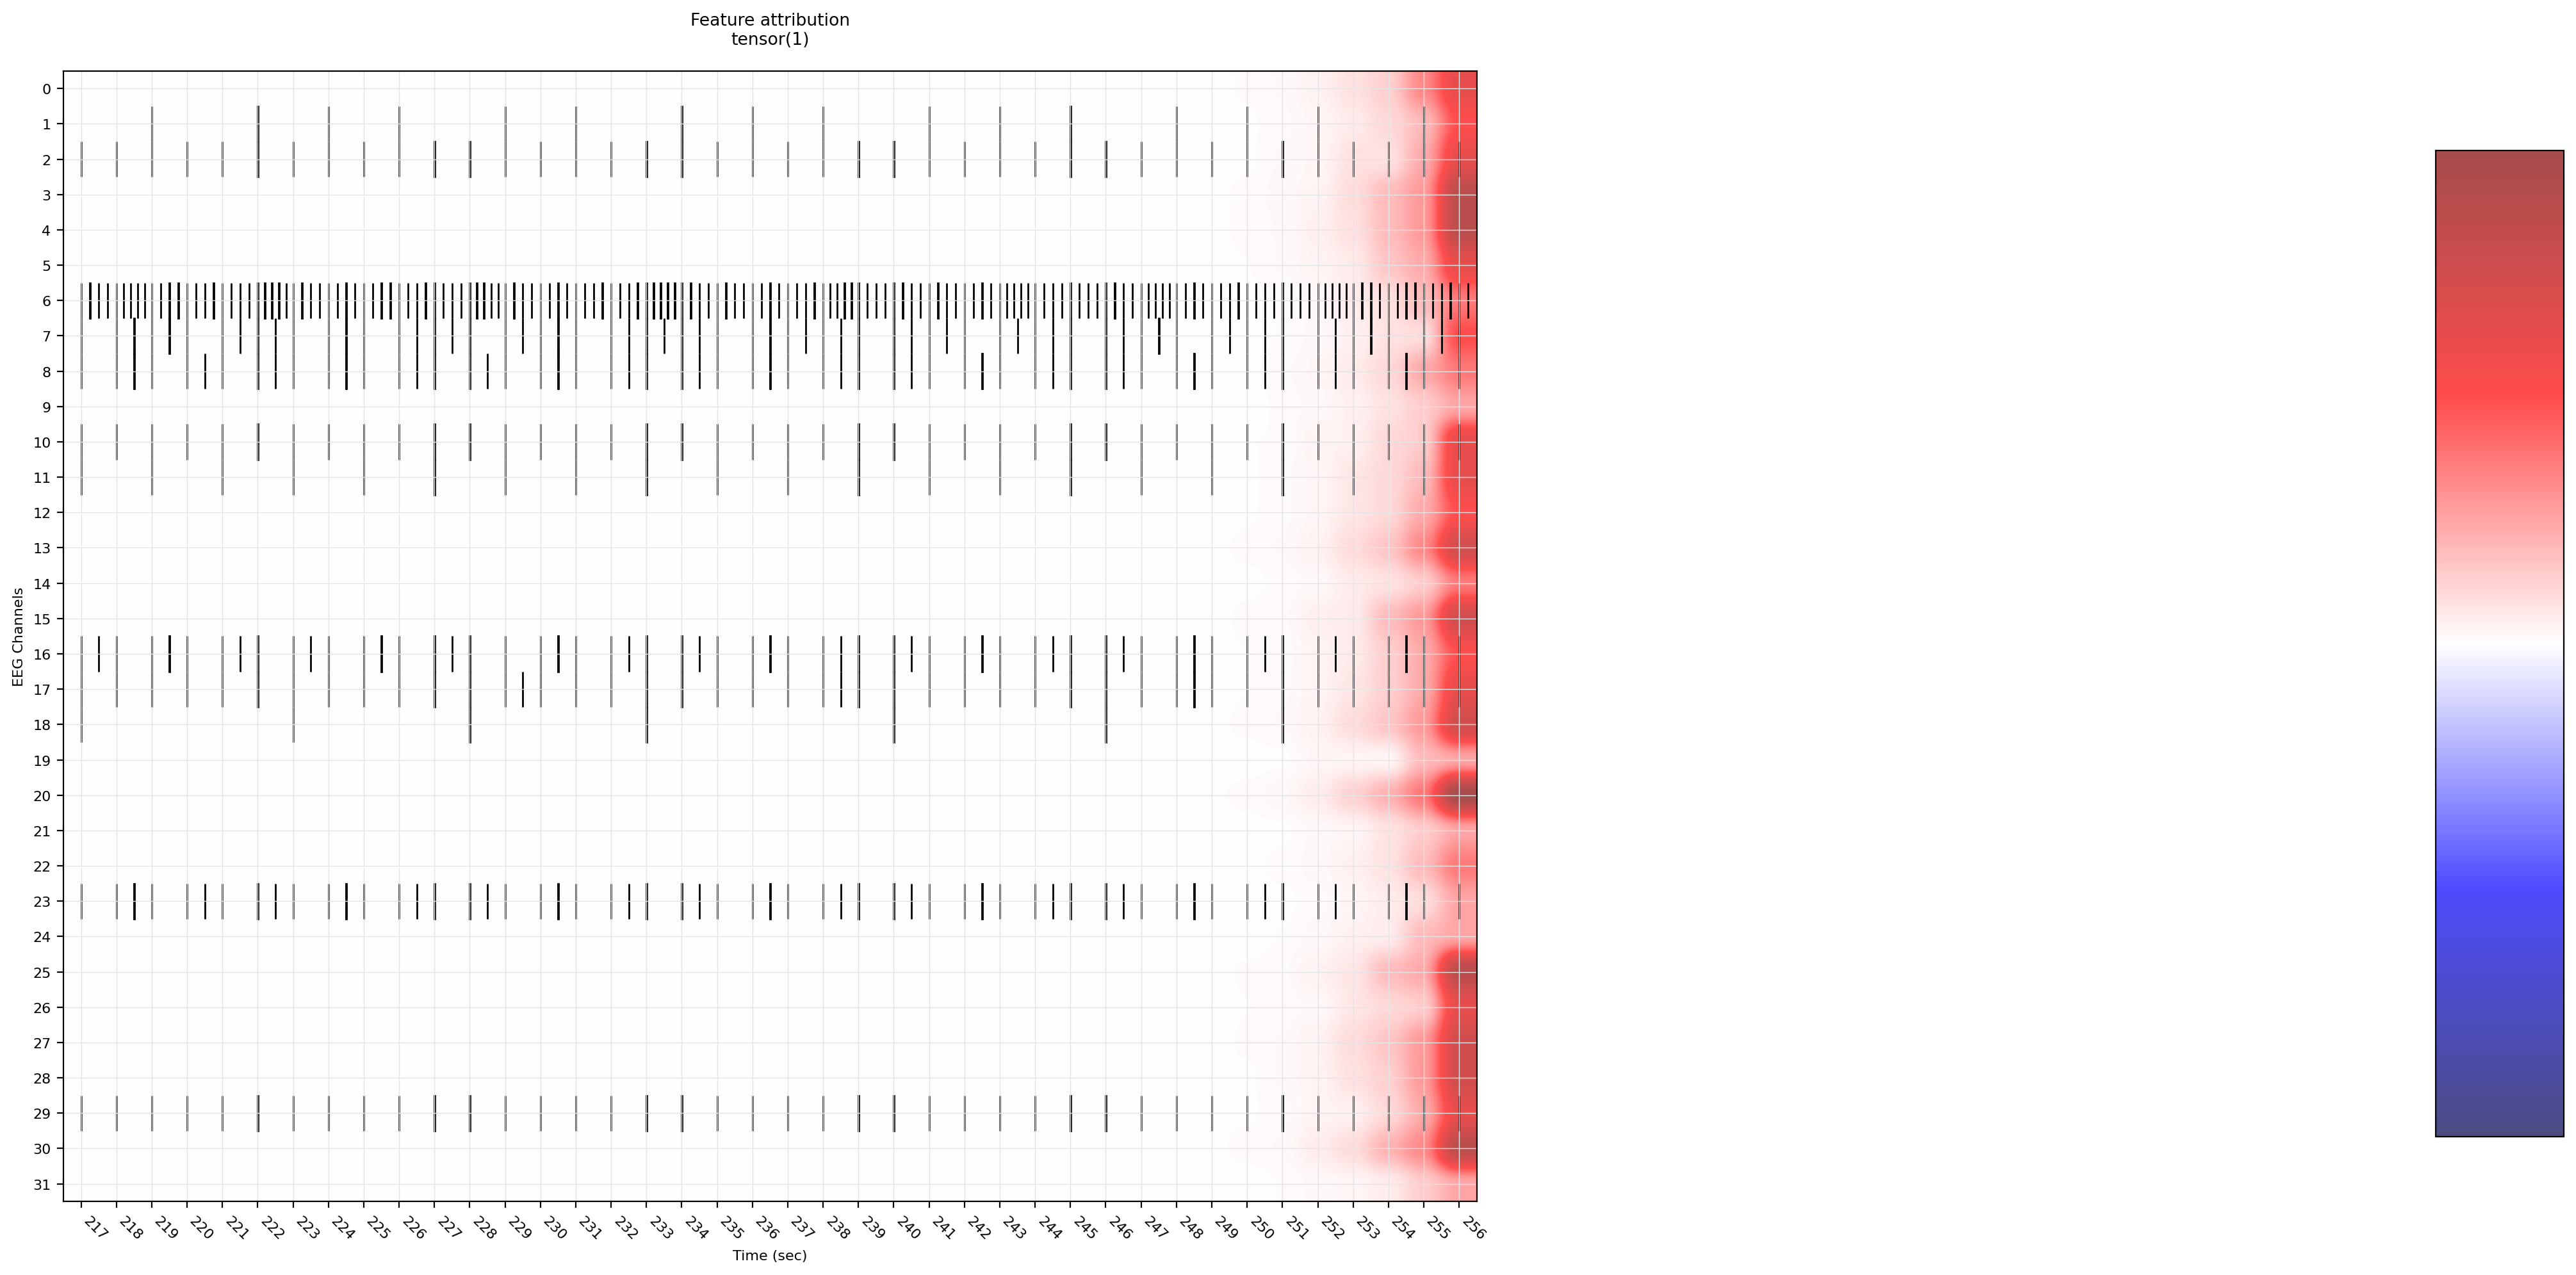

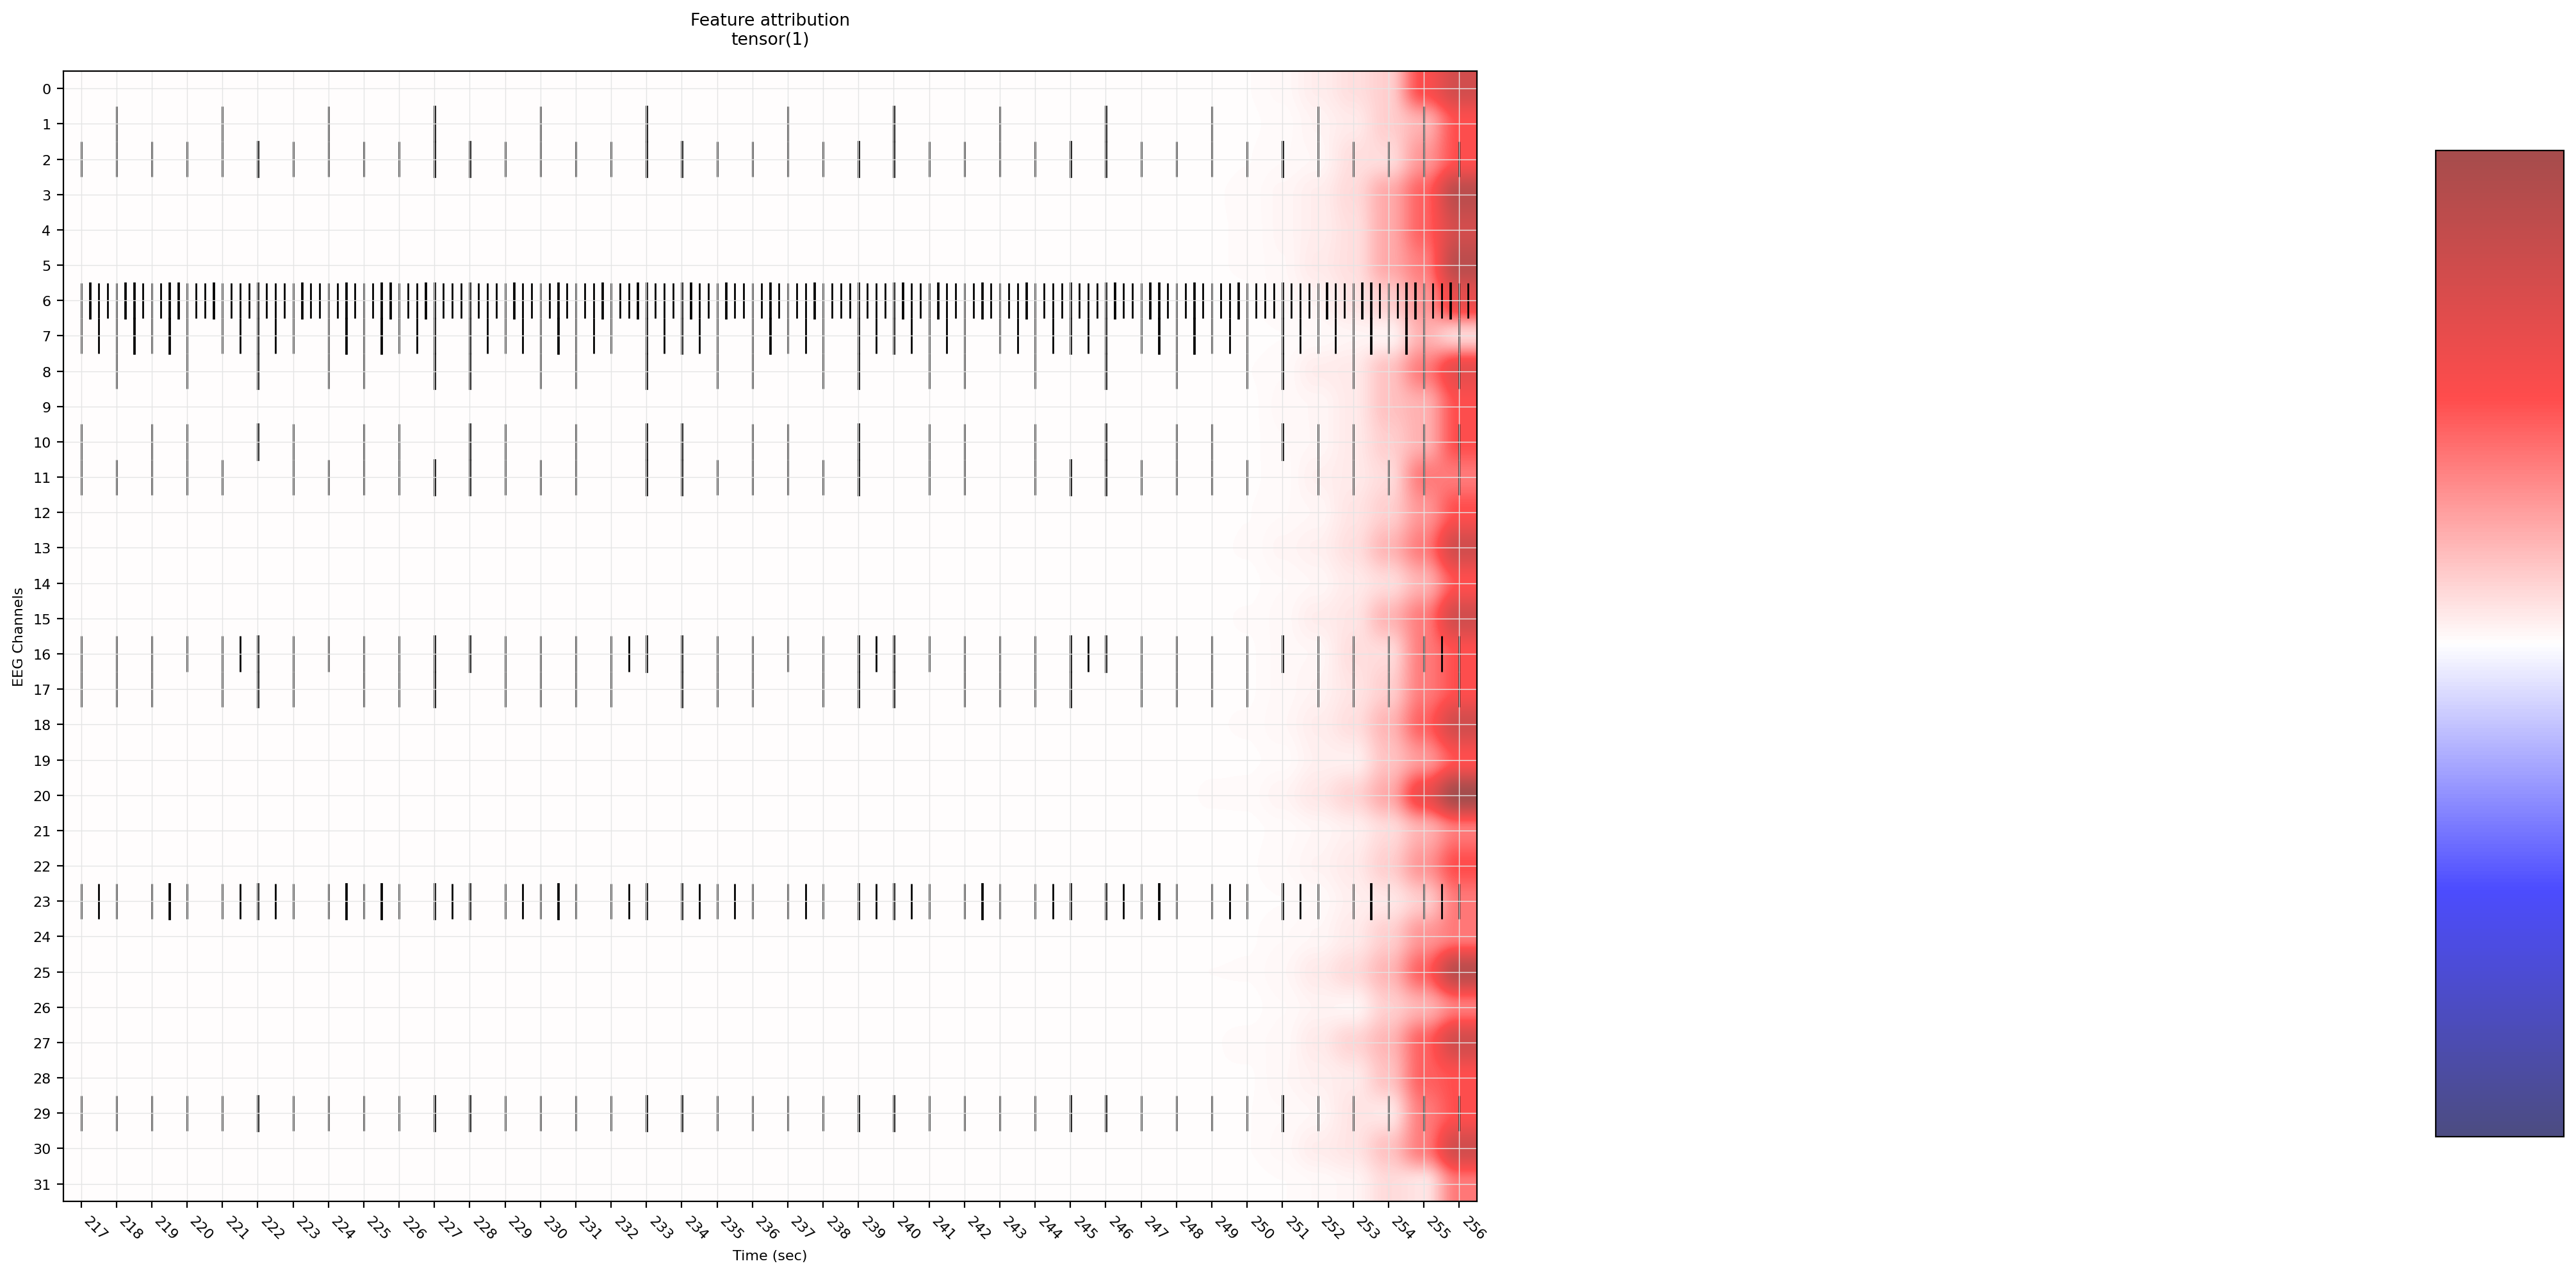

In [25]:
SMALL_SIZE = 8
plt.rc('font', size=SMALL_SIZE)
for i, sample in enumerate(data):
  e = testset_explanations[i]
  X_spikes = rec_dicts[i]['1_LIFTorch']['spikes']
  fig = plt.figure(tight_layout=True, frameon=False, figsize=(100,10),dpi=200)
  gs = gridspec.GridSpec(1,3)

  ax = fig.add_subplot(gs[0,0])
  titles = np.arange(512).astype(str)
  channels = ['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3',
  'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10',
  'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']

  visualize_attribution_class(X_spikes, e, 256, ax, fig, titles, channels)

  if i == 10:
    break